In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools
import json

### Intro
Dans ce notebook, j'ai cherché à visualiser la répartition de la réutilisation des process dans snakemake pour deux métriques : "tools" et "levenshtein". 
* "tools" considère qu'un processus p2 est réutilisé si il a le même ensemble d'outils qu'un autre processus p1. quand à "levenshtein", c'est si pour p2, son score de similarité est >85% à un processus p1.
* "levenshtein" est calculée comme suit, avec d = max(len(p1),len(p2)) : l(p1,p2) = (d-levenshtein(p1,p2))/d. C'est une normalisation qui nous permet d'avoir une mesure de similarité à partir d'une mesure de distance d'édition.
é
Pour obtenir les groupes de process similaires avec levenshtein, nous avons forcé la transitivité si l(p1,p2)>85% et l(p2,p3)>85%, p1,p2 et p3 sont dans le même groupe.
Ces calculs ont été effectués sur une base de processus snakemake contenant au moins un outil.
Ces calculs ont été effectués dans d'autres scripts : ils sont longs à effectuer (>3j pour 6500 process snk).

In [4]:
def importing_json_files(file_wf):
    f_wf = open(file_wf) #informations for nf
    # returns JSON object as
    # a dictionary
    wf = json.load(f_wf)
    f_wf.close
    return wf

#importing the wf and auth dict (github info)
dict_nf = importing_json_files('json/wf_new_crawl_nextflow.json')
auth_nf = importing_json_files('json/author_clem_nf.json')
dict_snk = importing_json_files('json/wf_crawl_snakemake.json')
auth_snk = importing_json_files('json/author_clem_snk.json')


In [6]:
#importing the similarity groups df

df_snk = pd.read_csv("csv/df_groups_snk.csv")
df_sim_snk = pd.read_csv("csv/df_sim_snk.csv")
df_nf = pd.read_csv("csv/df_groups_nf.csv")
df_sim_nf = pd.read_csv("csv/df_groups_snk.csv")
df_sim_nf_lev = pd.read_csv('csv/df_groups_ngram_tools_nf.csv')

def grouping_sim_df (df_sim_n):
    df_sim = df_sim_n.copy()
    vals = set(df_sim["nb_reuse"])
    tot_group = len(df_sim_n)
    tot_wf = sum(df_sim_n["nb_wf"])
    tot_own = sum(df_sim_n["nb_own"])

    df_sim_group = pd.DataFrame(columns=["nb_reuse", "nb_proc","prop_proc","nb_own","prop_own","nb_wf","prop_wf"])
    for val in vals :
        sec_df = df_sim.loc[df_sim["nb_reuse"]==val]
        nb_proc = len(sec_df)
        prop_proc = nb_proc/tot_group
        nb_own = sum(sec_df["nb_own"])
        prop_own = nb_own/tot_own
        nb_wf = sum(sec_df["nb_wf"])
        prop_wf = nb_wf/tot_wf
        df_sim_group = df_sim_group.append({"nb_reuse":val,
                                            "nb_proc":nb_proc,
                                            "prop_proc":prop_proc*100.0,
                                            "nb_own":nb_own,
                                            "prop_own":prop_own*100.0,
                                            "nb_wf":nb_wf,
                                            "prop_wf":prop_wf*100.0}, ignore_index = True)
    
    return df_sim_group.sort_values(by=["nb_reuse"], ascending=True)

df_nf_lev = grouping_sim_df(df_sim_nf_lev)

In [10]:
#grouping the lev sim groups

def grouping_sim_df_wf (df_sim_n):
    df_sim = df_sim_n.copy()
    vals = set(df_sim["nb_wf"])
    tot_group = len(df_sim_n)

    df_sim_group = pd.DataFrame(columns=["nb_proc","prop_proc","nb_wf"])
    for val in vals :
        sec_df = df_sim.loc[df_sim["nb_wf"]==val]
        nb_proc = len(sec_df)
        prop_proc = nb_proc/tot_group
        df_sim_group = df_sim_group.append({"nb_proc":nb_proc,
                                            "prop_proc":prop_proc*100.0,
                                            "nb_wf":val}, ignore_index = True)
    
    return df_sim_group.sort_values(by=["nb_wf"], ascending=False)

df_nf_lev_wf =grouping_sim_df_wf(df_sim_nf_lev )

### Réutilisation des process

Regardons la répartition de la réutilisation des process selon les différentes métriques :
- fréquence de réutilisation des process (combien de process sont utilisés n fois ?)
- dans combien de workflows les process sont ils utilisés ?

Note : On calcule ces métriques sur la base complète de workflows et sur la base de workflows uniques

In [11]:
def disp_fig_props(df_tot,sys):
    fig = df_tot.plot(x="nb_reuse",y=["prop_proc_lev","prop_proc_tools"], kind="bar", color = ['green','blue'], label = ['lev','tools'])
    fig.set_xticklabels(fig.get_xticklabels(), rotation=80, size=5)
    fig.set_xlabel("Number of times used with the metric 'levenshtein' and the metric 'tools' in "+sys)
    fig.set_ylabel('Percent of processors')
    fig.legend(loc='best')
    fig.set_yscale('log')
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return fig

In [12]:
def make_df_tot(df_lev,df_tools,metric):
    df_lev["prop_proc_lev"]=df_lev["prop_proc"]
    df_tools["prop_proc_tools"]=df_tools["prop_proc"]
    df_lev["prop_wf_lev"]=df_lev["prop_wf"]
    df_tools["prop_wf_tools"]=df_tools["prop_wf"]
    df_tot = pd.merge(df_lev[[metric,"prop_proc_lev","prop_wf_lev"]], df_tools[[metric,"prop_proc_tools","prop_wf_tools"]],on=metric,how="outer")
    df_tot = df_tot.fillna(0)
    df_tot=df_tot.sort_values(by=[metric], ascending=True)
    return df_tot

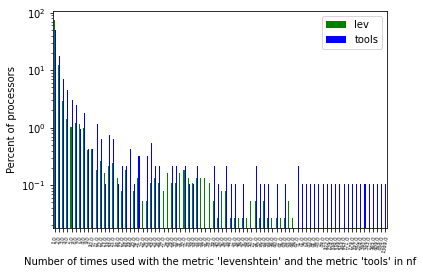

In [13]:
df_tot_nf=make_df_tot(df_nf_lev,df_nf,"nb_reuse")
fig_snk = disp_fig_props(df_tot_nf,'nf')

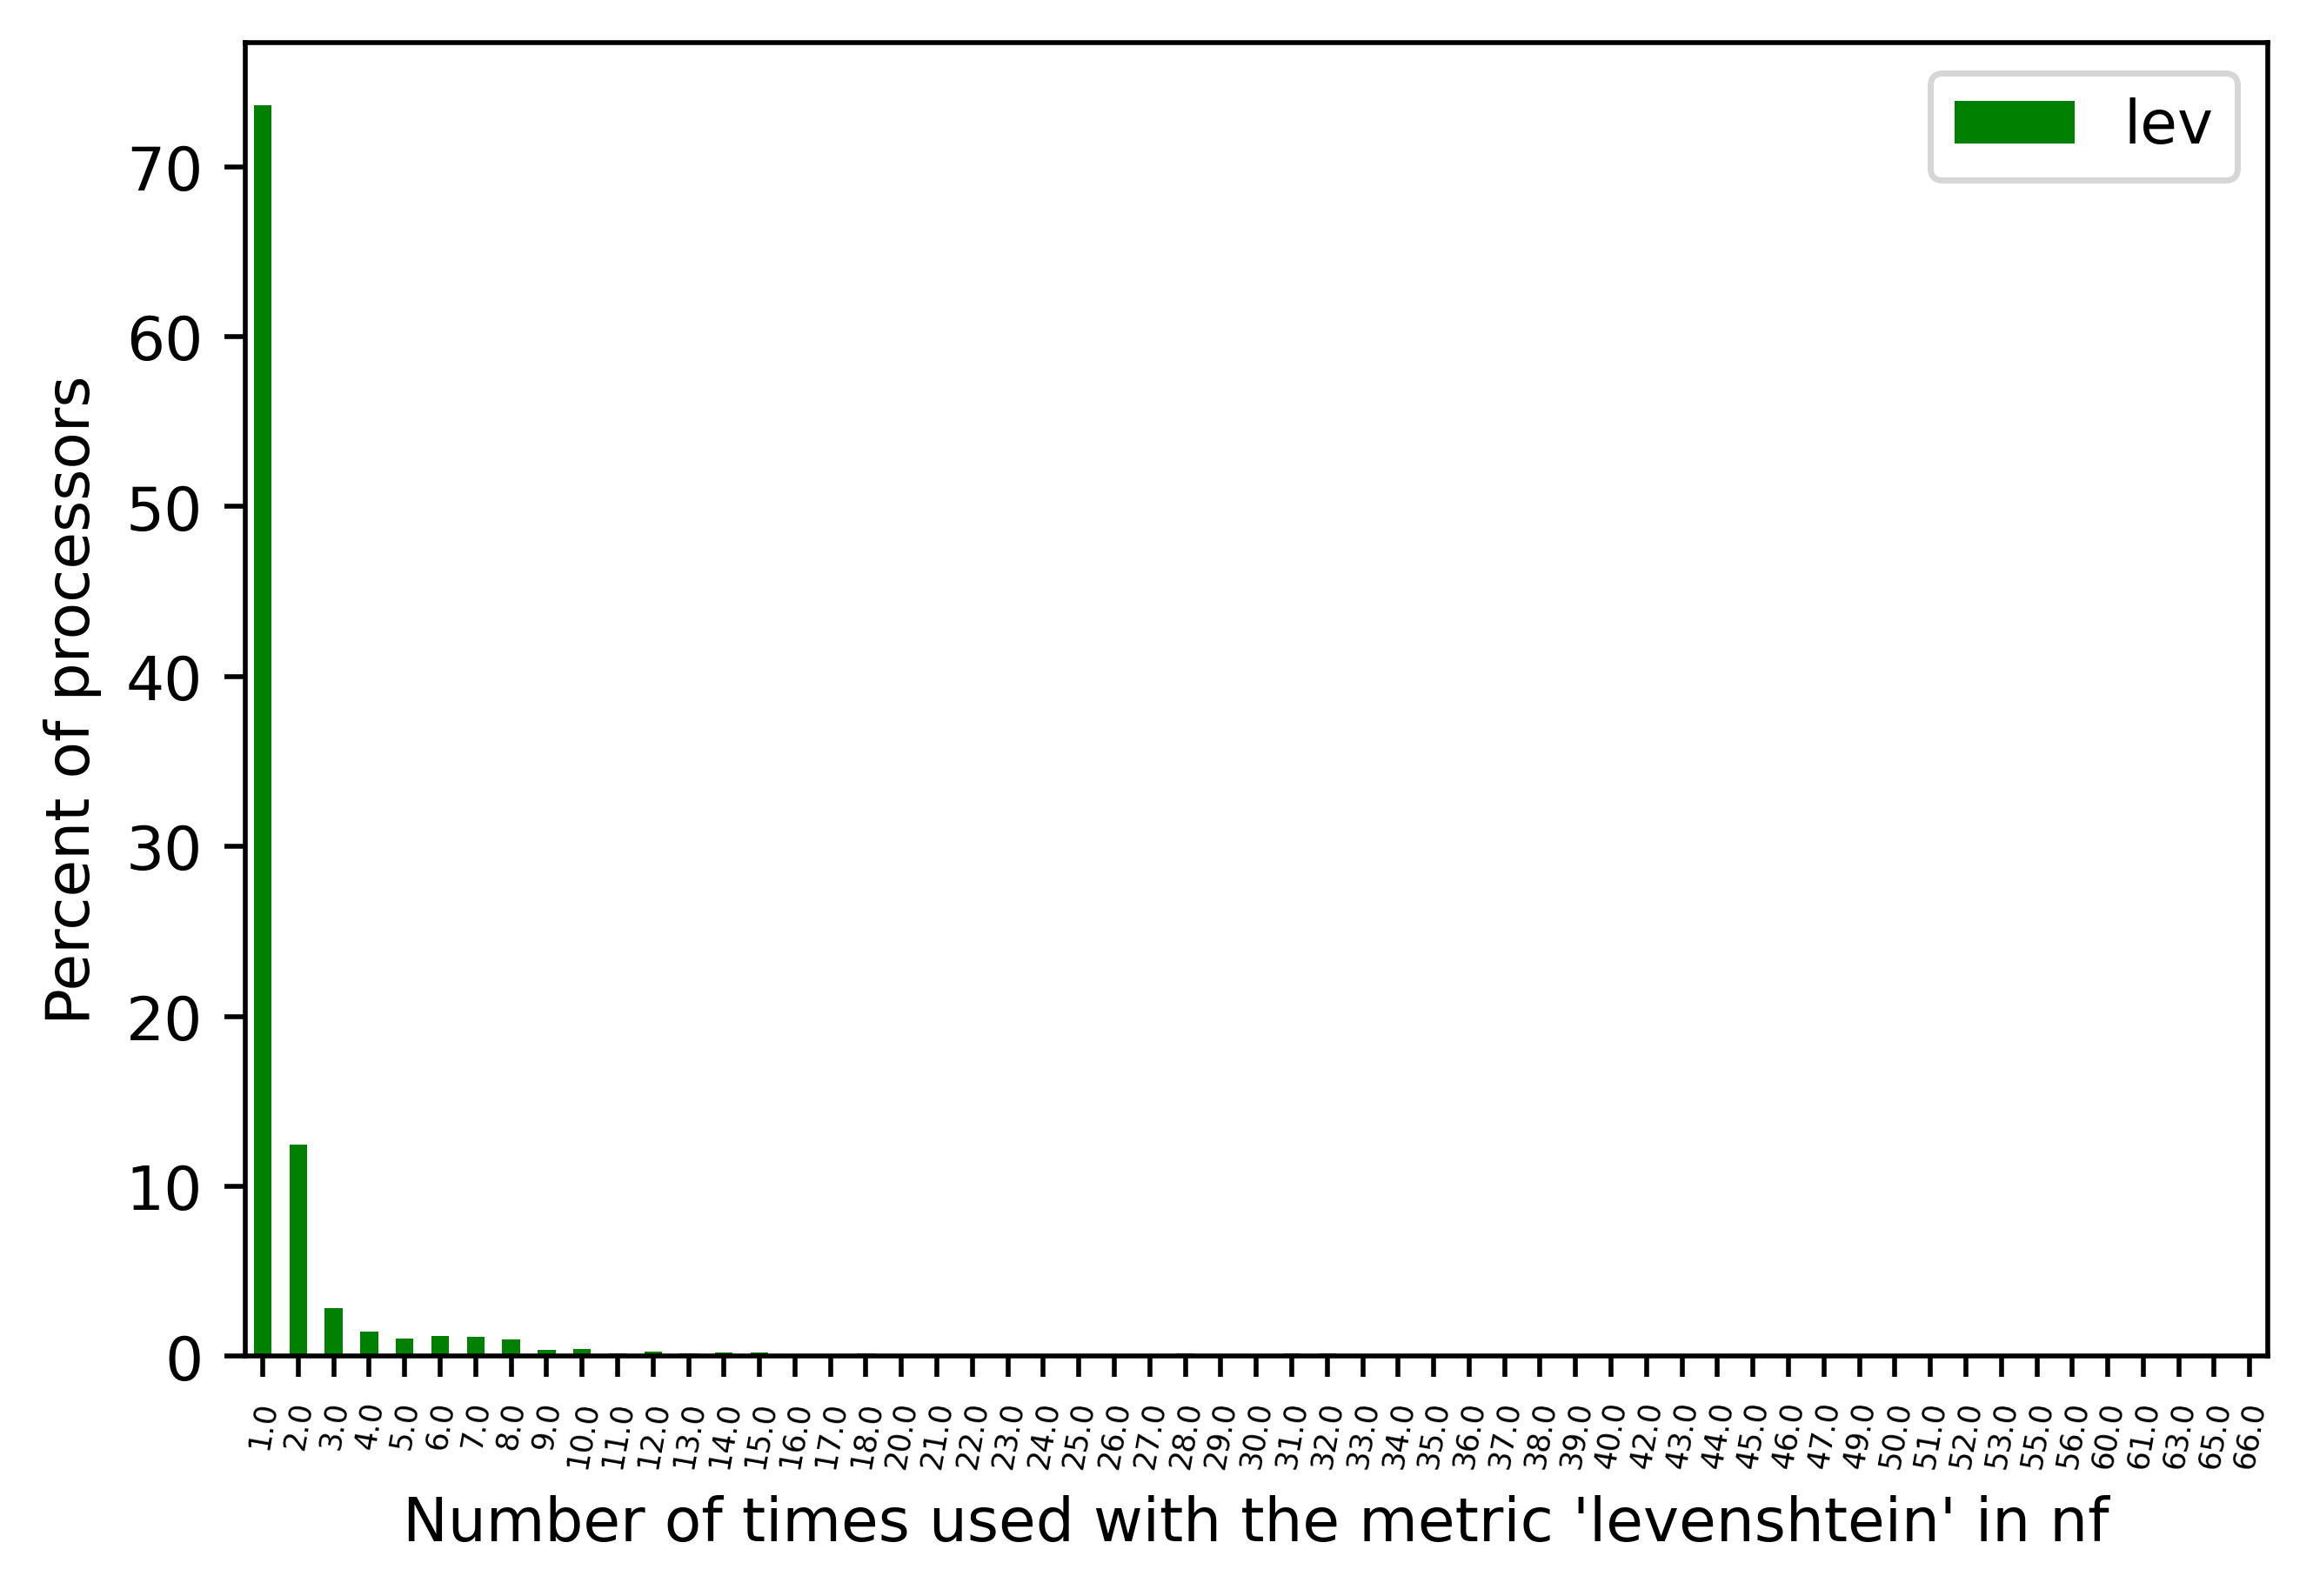

In [15]:
fig2 = df_nf_lev.plot(x="nb_reuse",y="prop_proc", kind="bar", color = 'green', label = 'lev')
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=80, size=5)
fig2.set_xlabel("Number of times used with the metric 'levenshtein' in nf")
fig2.set_ylabel('Percent of processors')
fig2.legend(loc='best')
#fig2.set_yscale('log')
plt.show()
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500

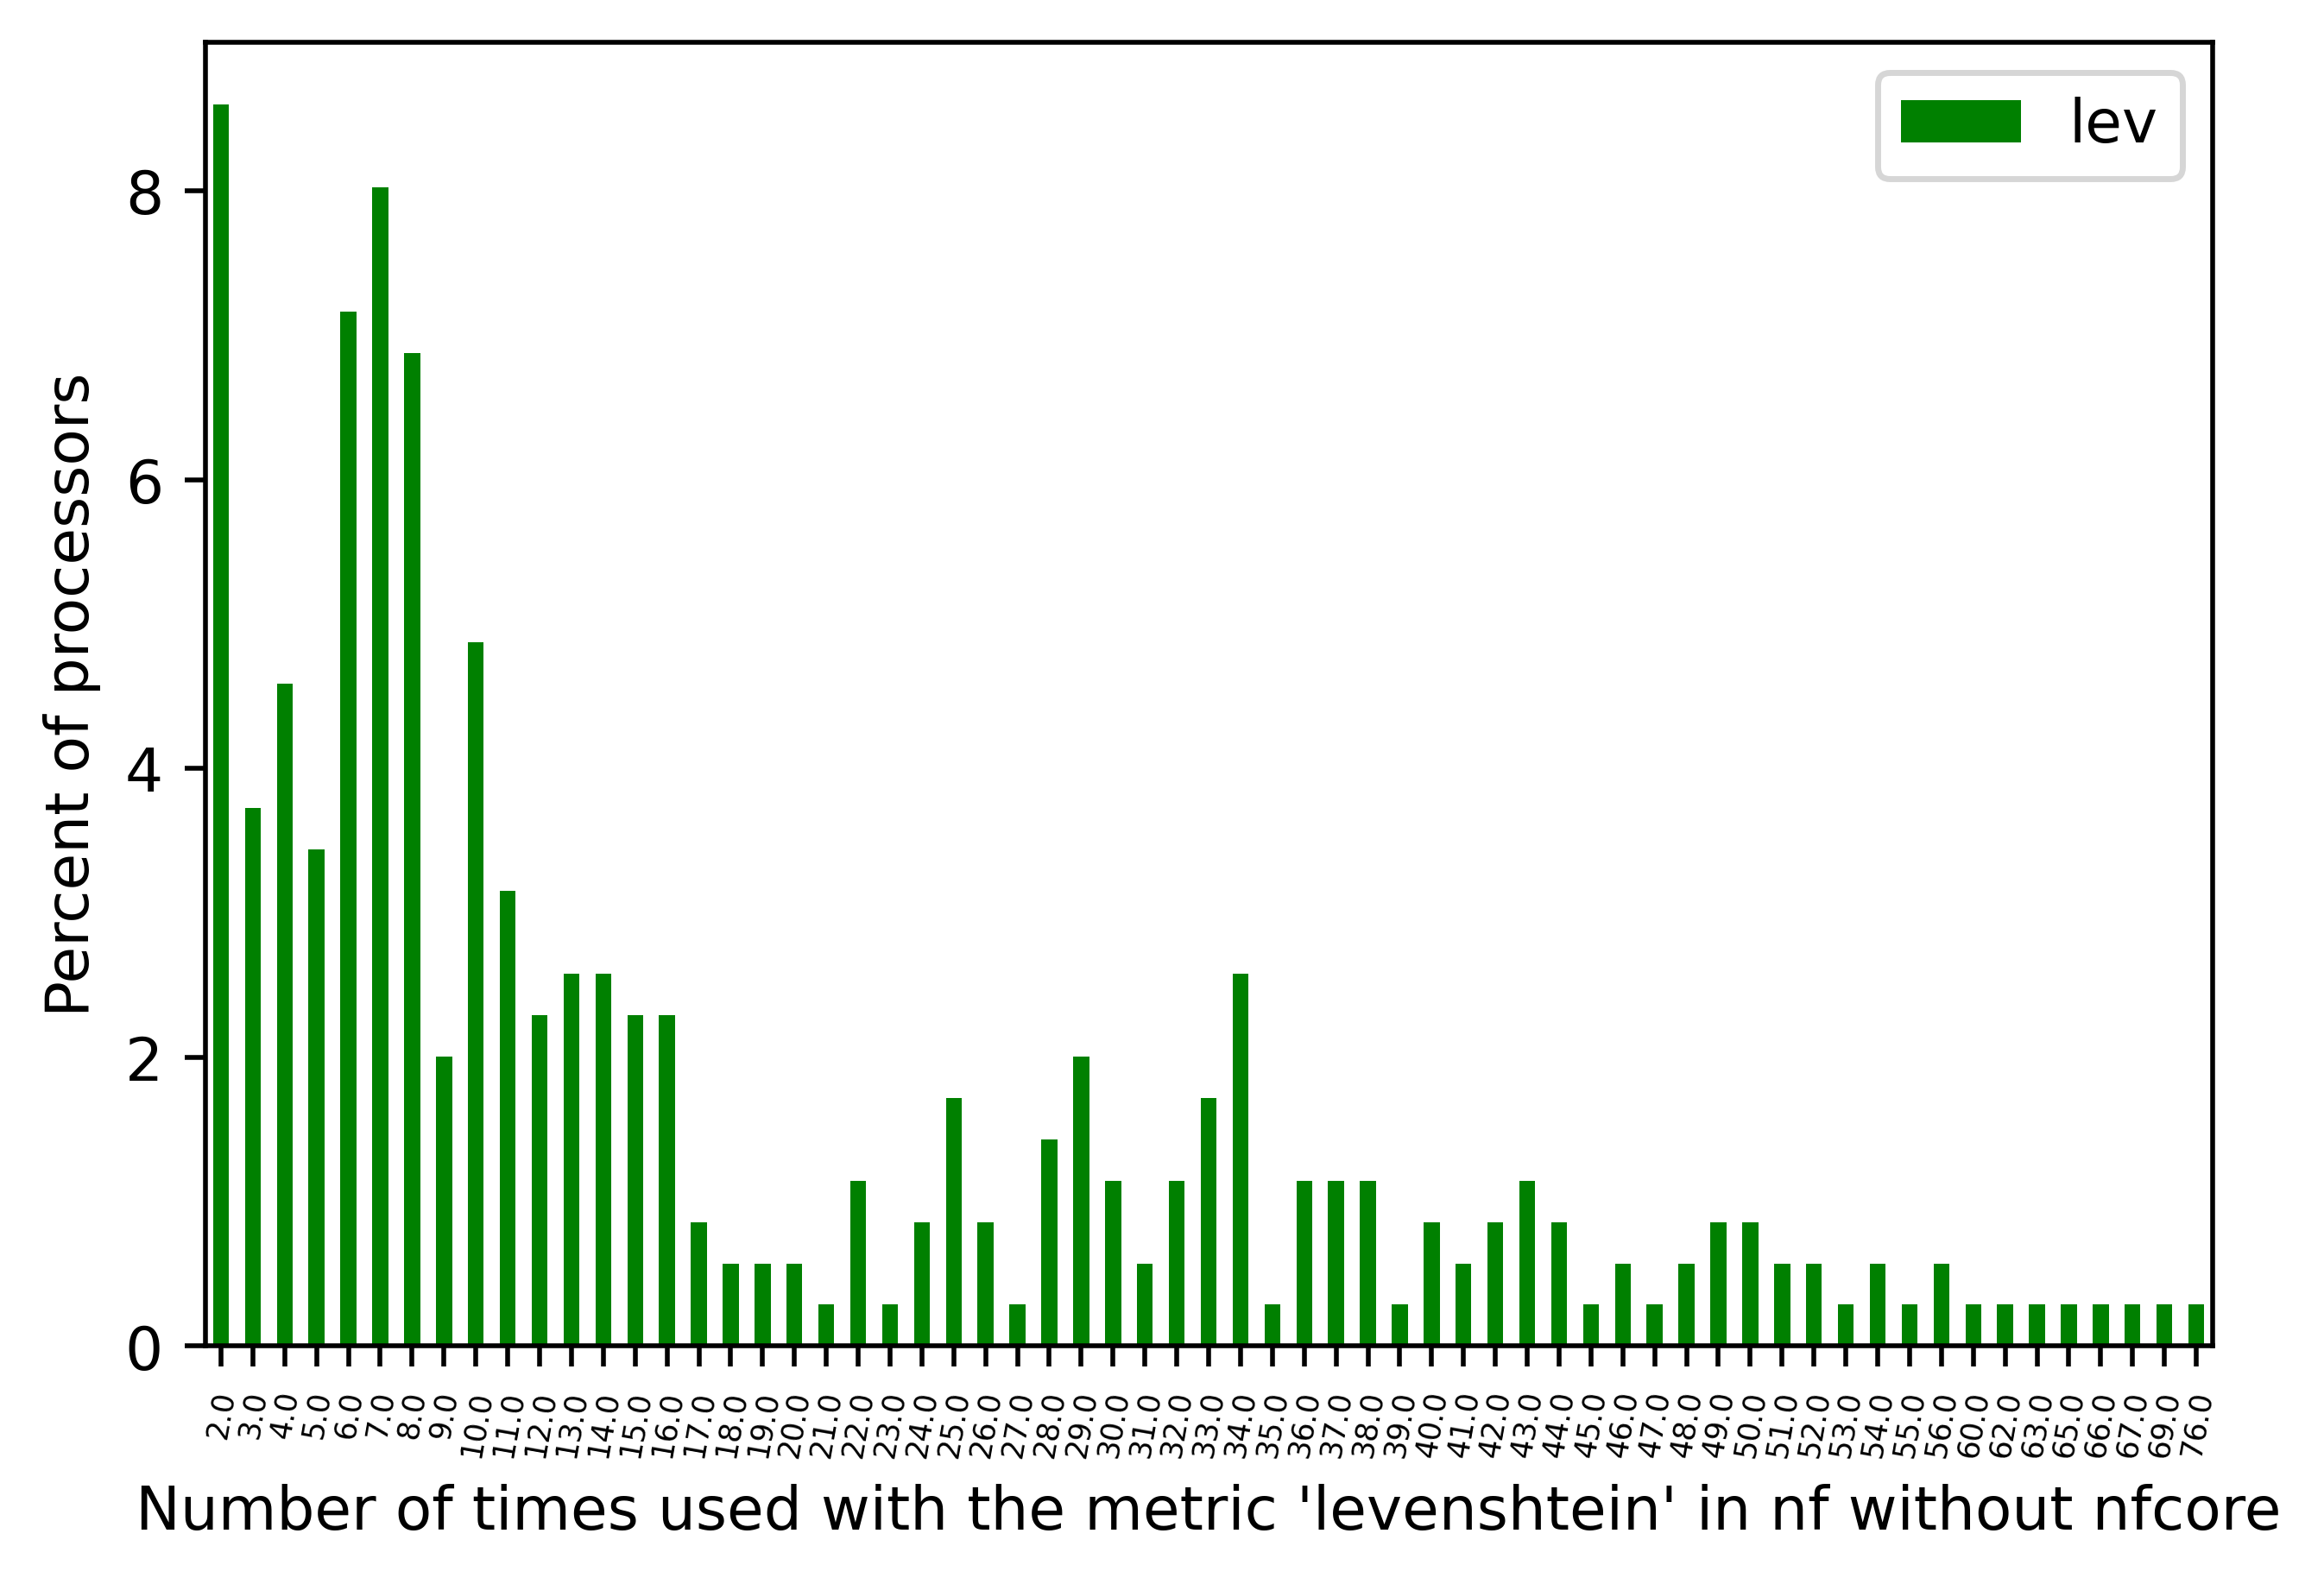

In [64]:
fig2 = df_nf_lev_wo_nfc.plot(x="nb_reuse",y="prop_proc", kind="bar", color = 'green', label = 'lev')
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=80, size=5)
fig2.set_xlabel("Number of times used with the metric 'levenshtein' in nf without nfcore")
fig2.set_ylabel('Percent of processors')
fig2.legend(loc='best')
#fig2.set_yscale('log')
plt.show()
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500

Regardons maintenant répartition de la réutilisation des process au sein des workflows : dans cb de workflows les process sont ils réutilisés ? 
(nb : les workflows sont considérés comme uniques)

In [55]:
def disp_fig_props_wf(df_tot,sys):
    fig = df_tot.plot(x="nb_reuse",y=["prop_wf_lev","prop_wf_tools"], kind="bar", color = ['green','blue'], label = ['lev','tools'])
    fig.set_xticklabels(fig.get_xticklabels(), rotation=80, size=5)
    fig.set_xlabel("Number of wf used in with the metric 'levenshtein' and the metric 'tools' in "+sys)
    fig.set_ylabel('Nb of workflows')
    fig.legend(loc='best')
    #fig.set_yscale('log')
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return fig

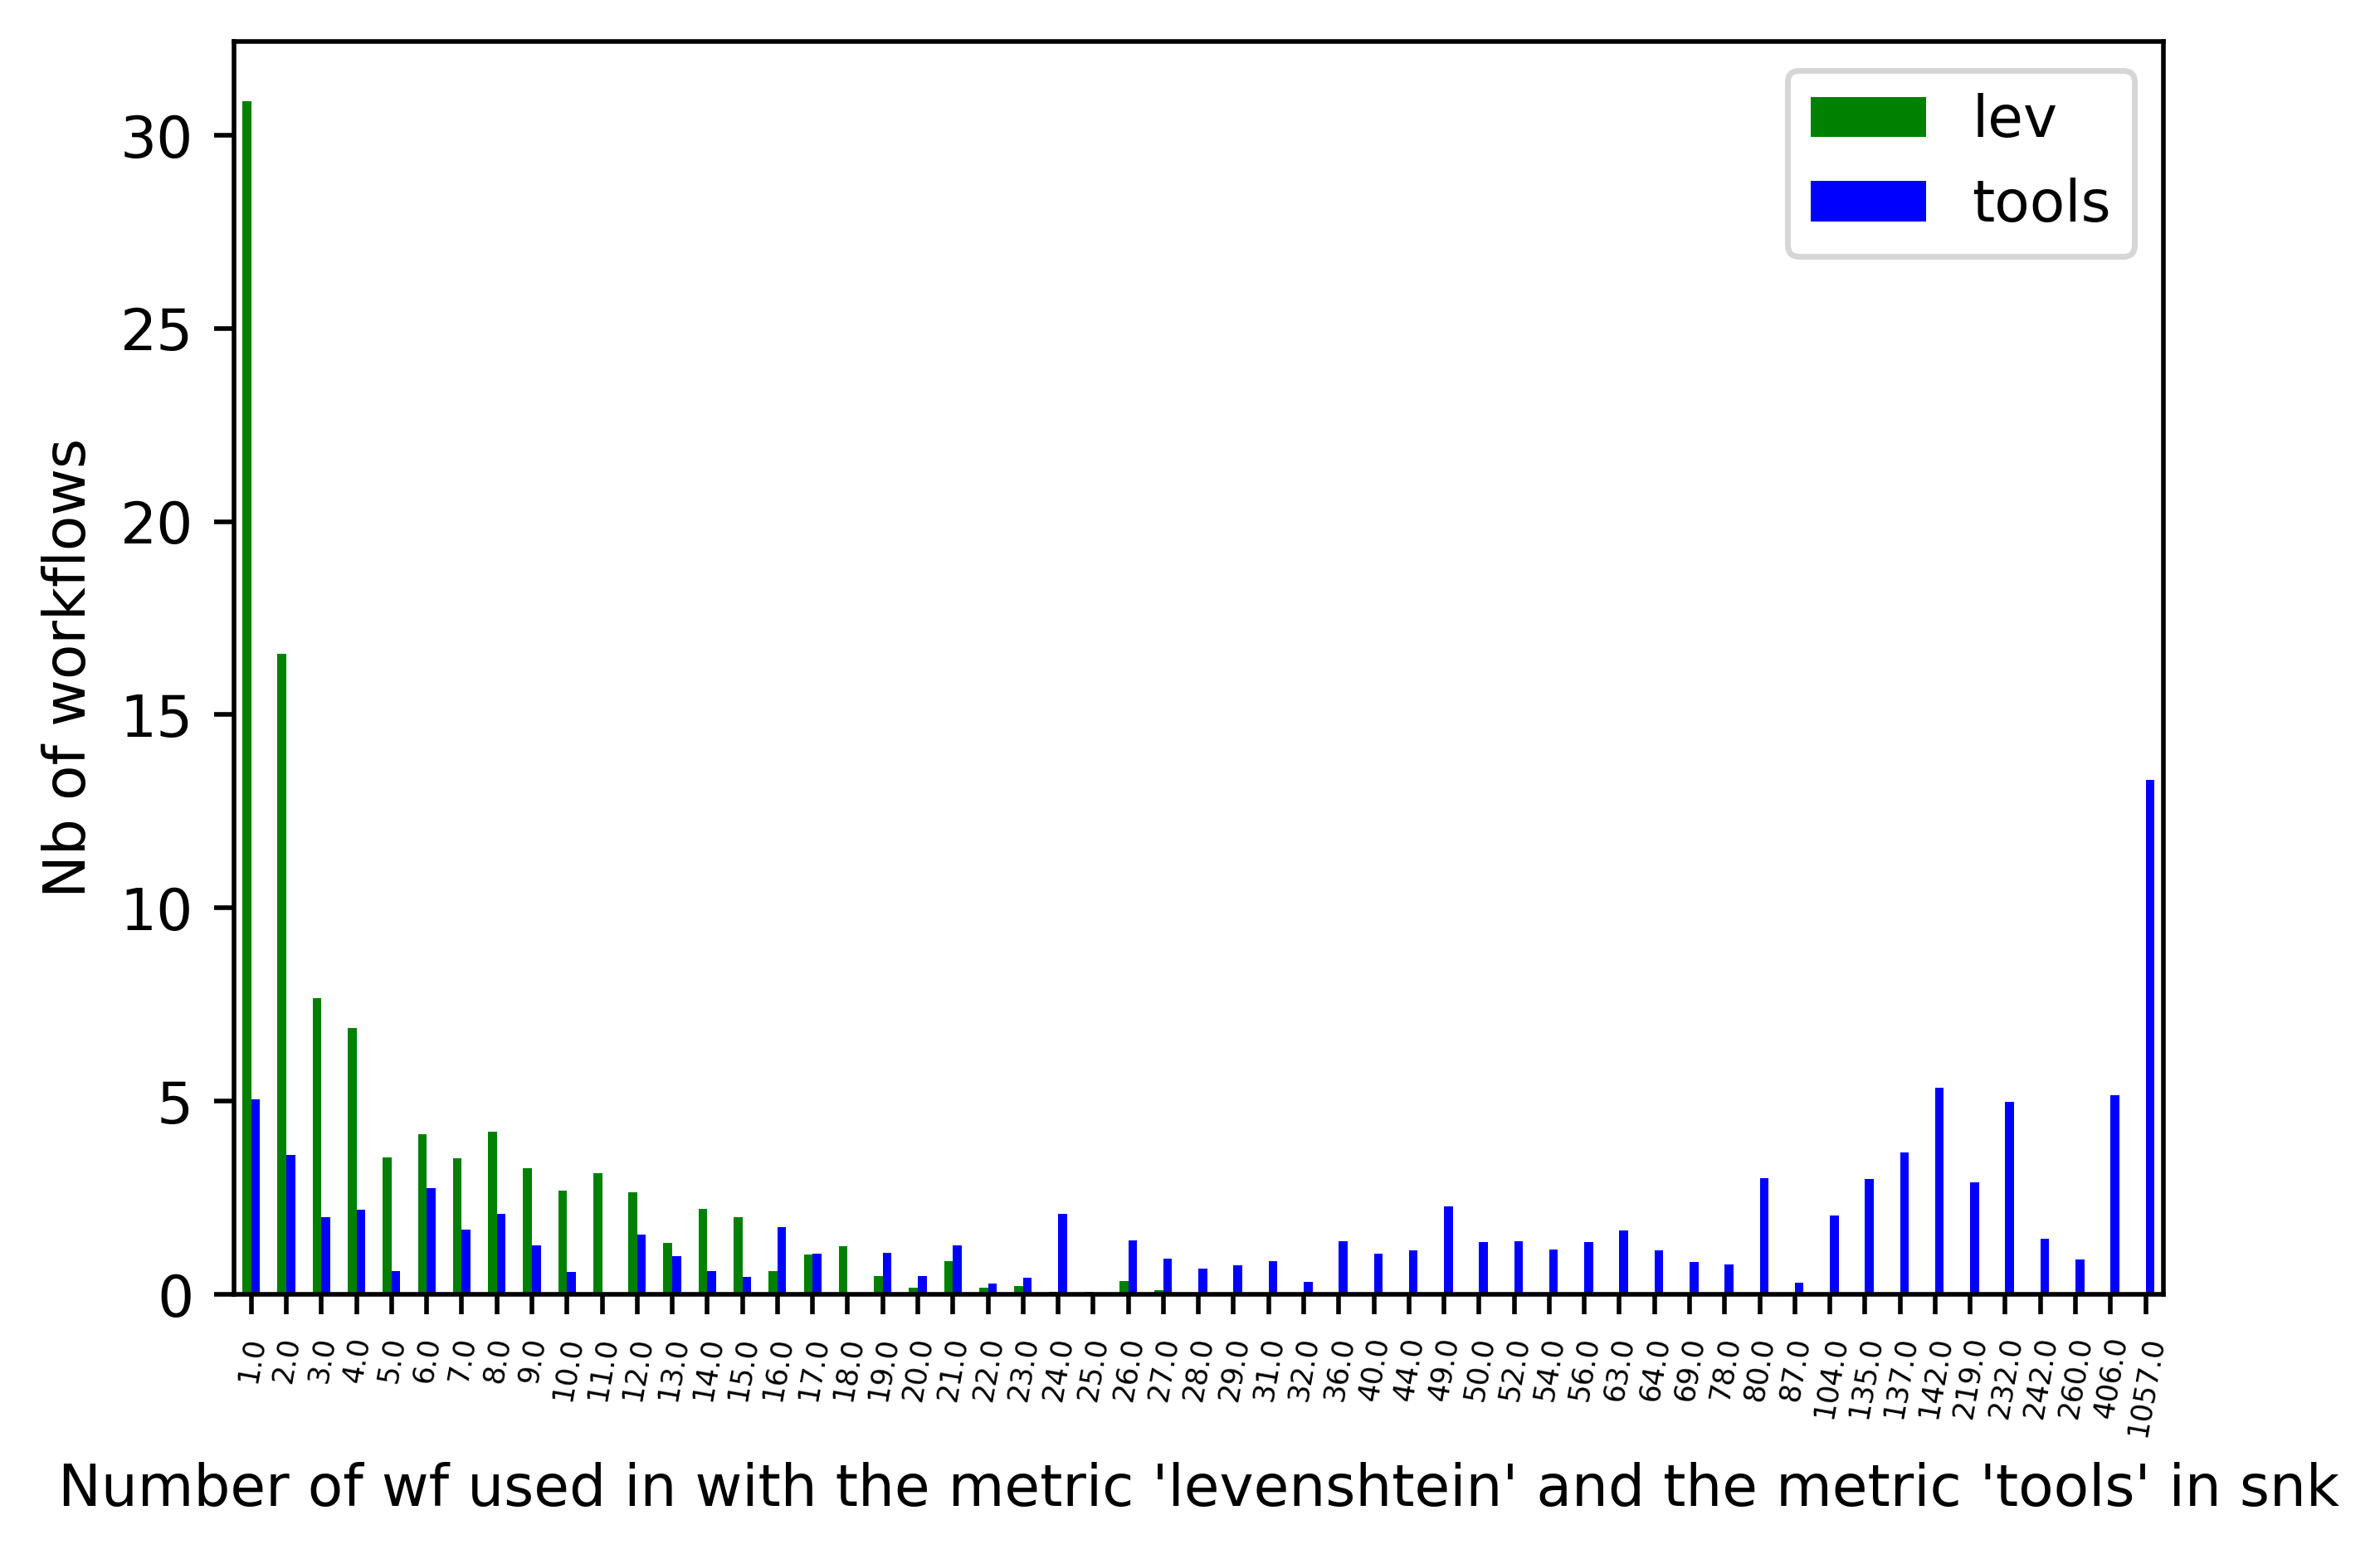

In [56]:
fig_snk_wf = disp_fig_props_wf(df_tot,'snk')

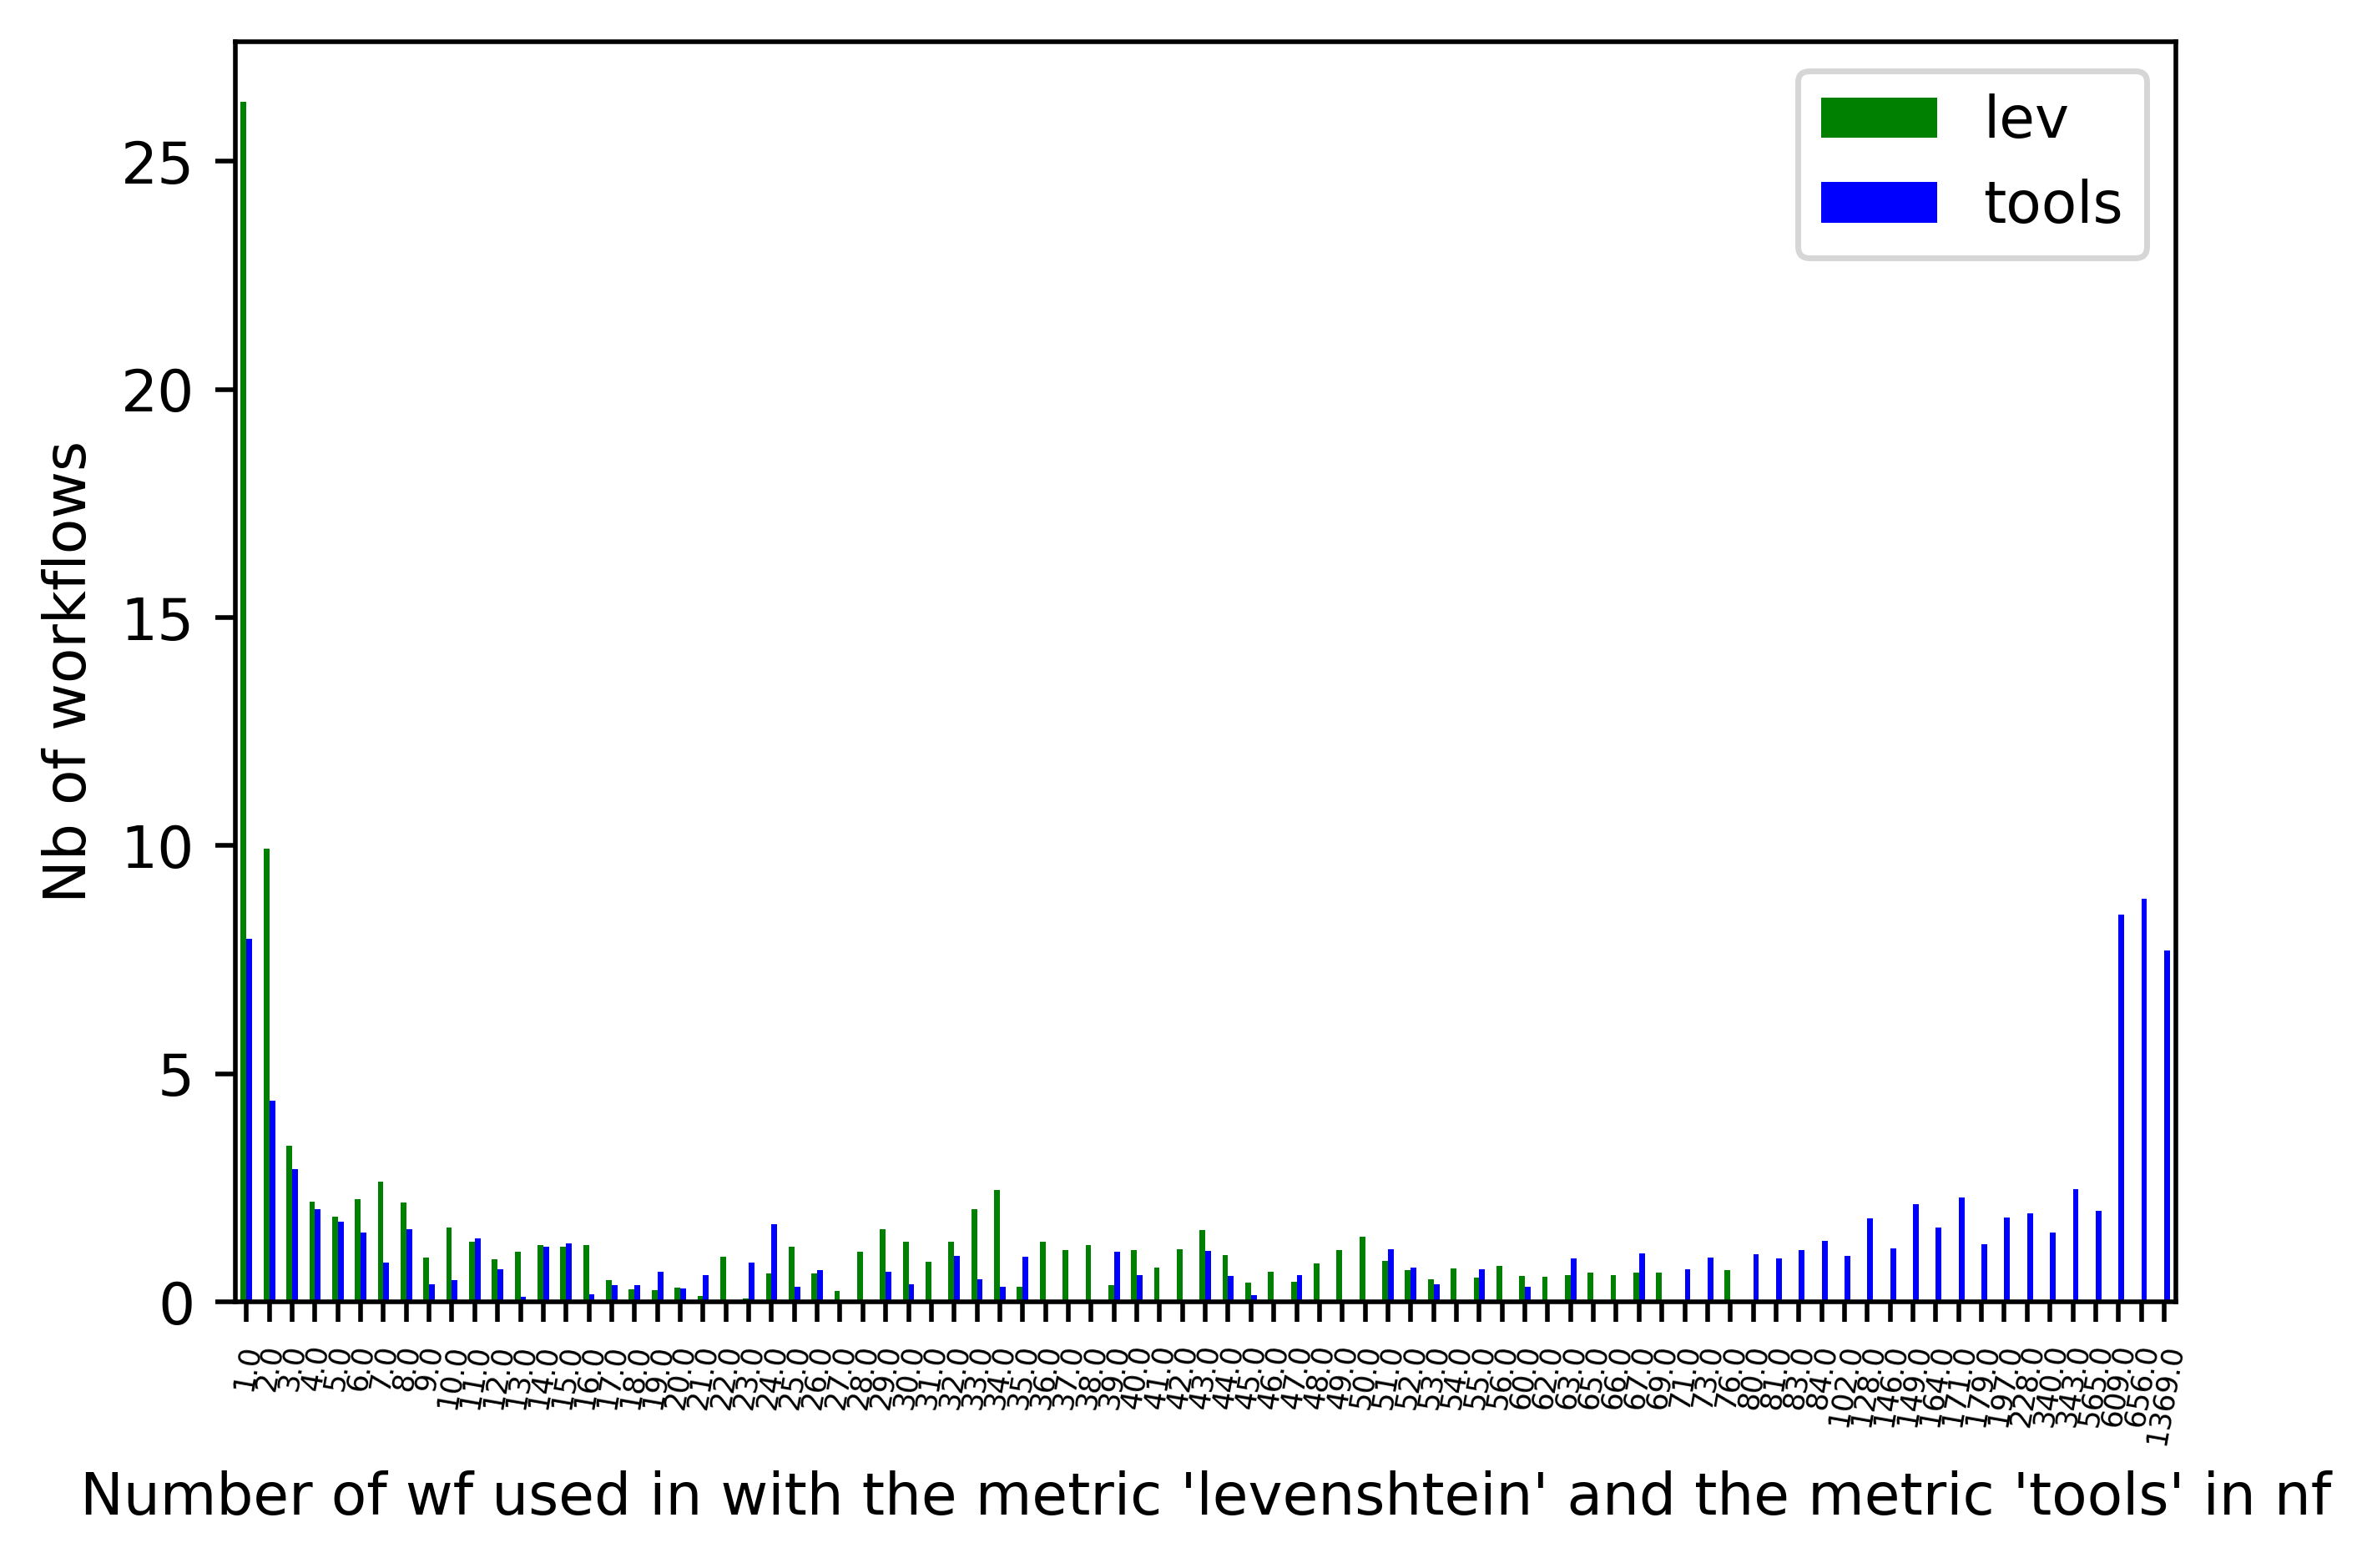

In [57]:
fig_nf_wf = disp_fig_props_wf(df_tot_nf,'nf')

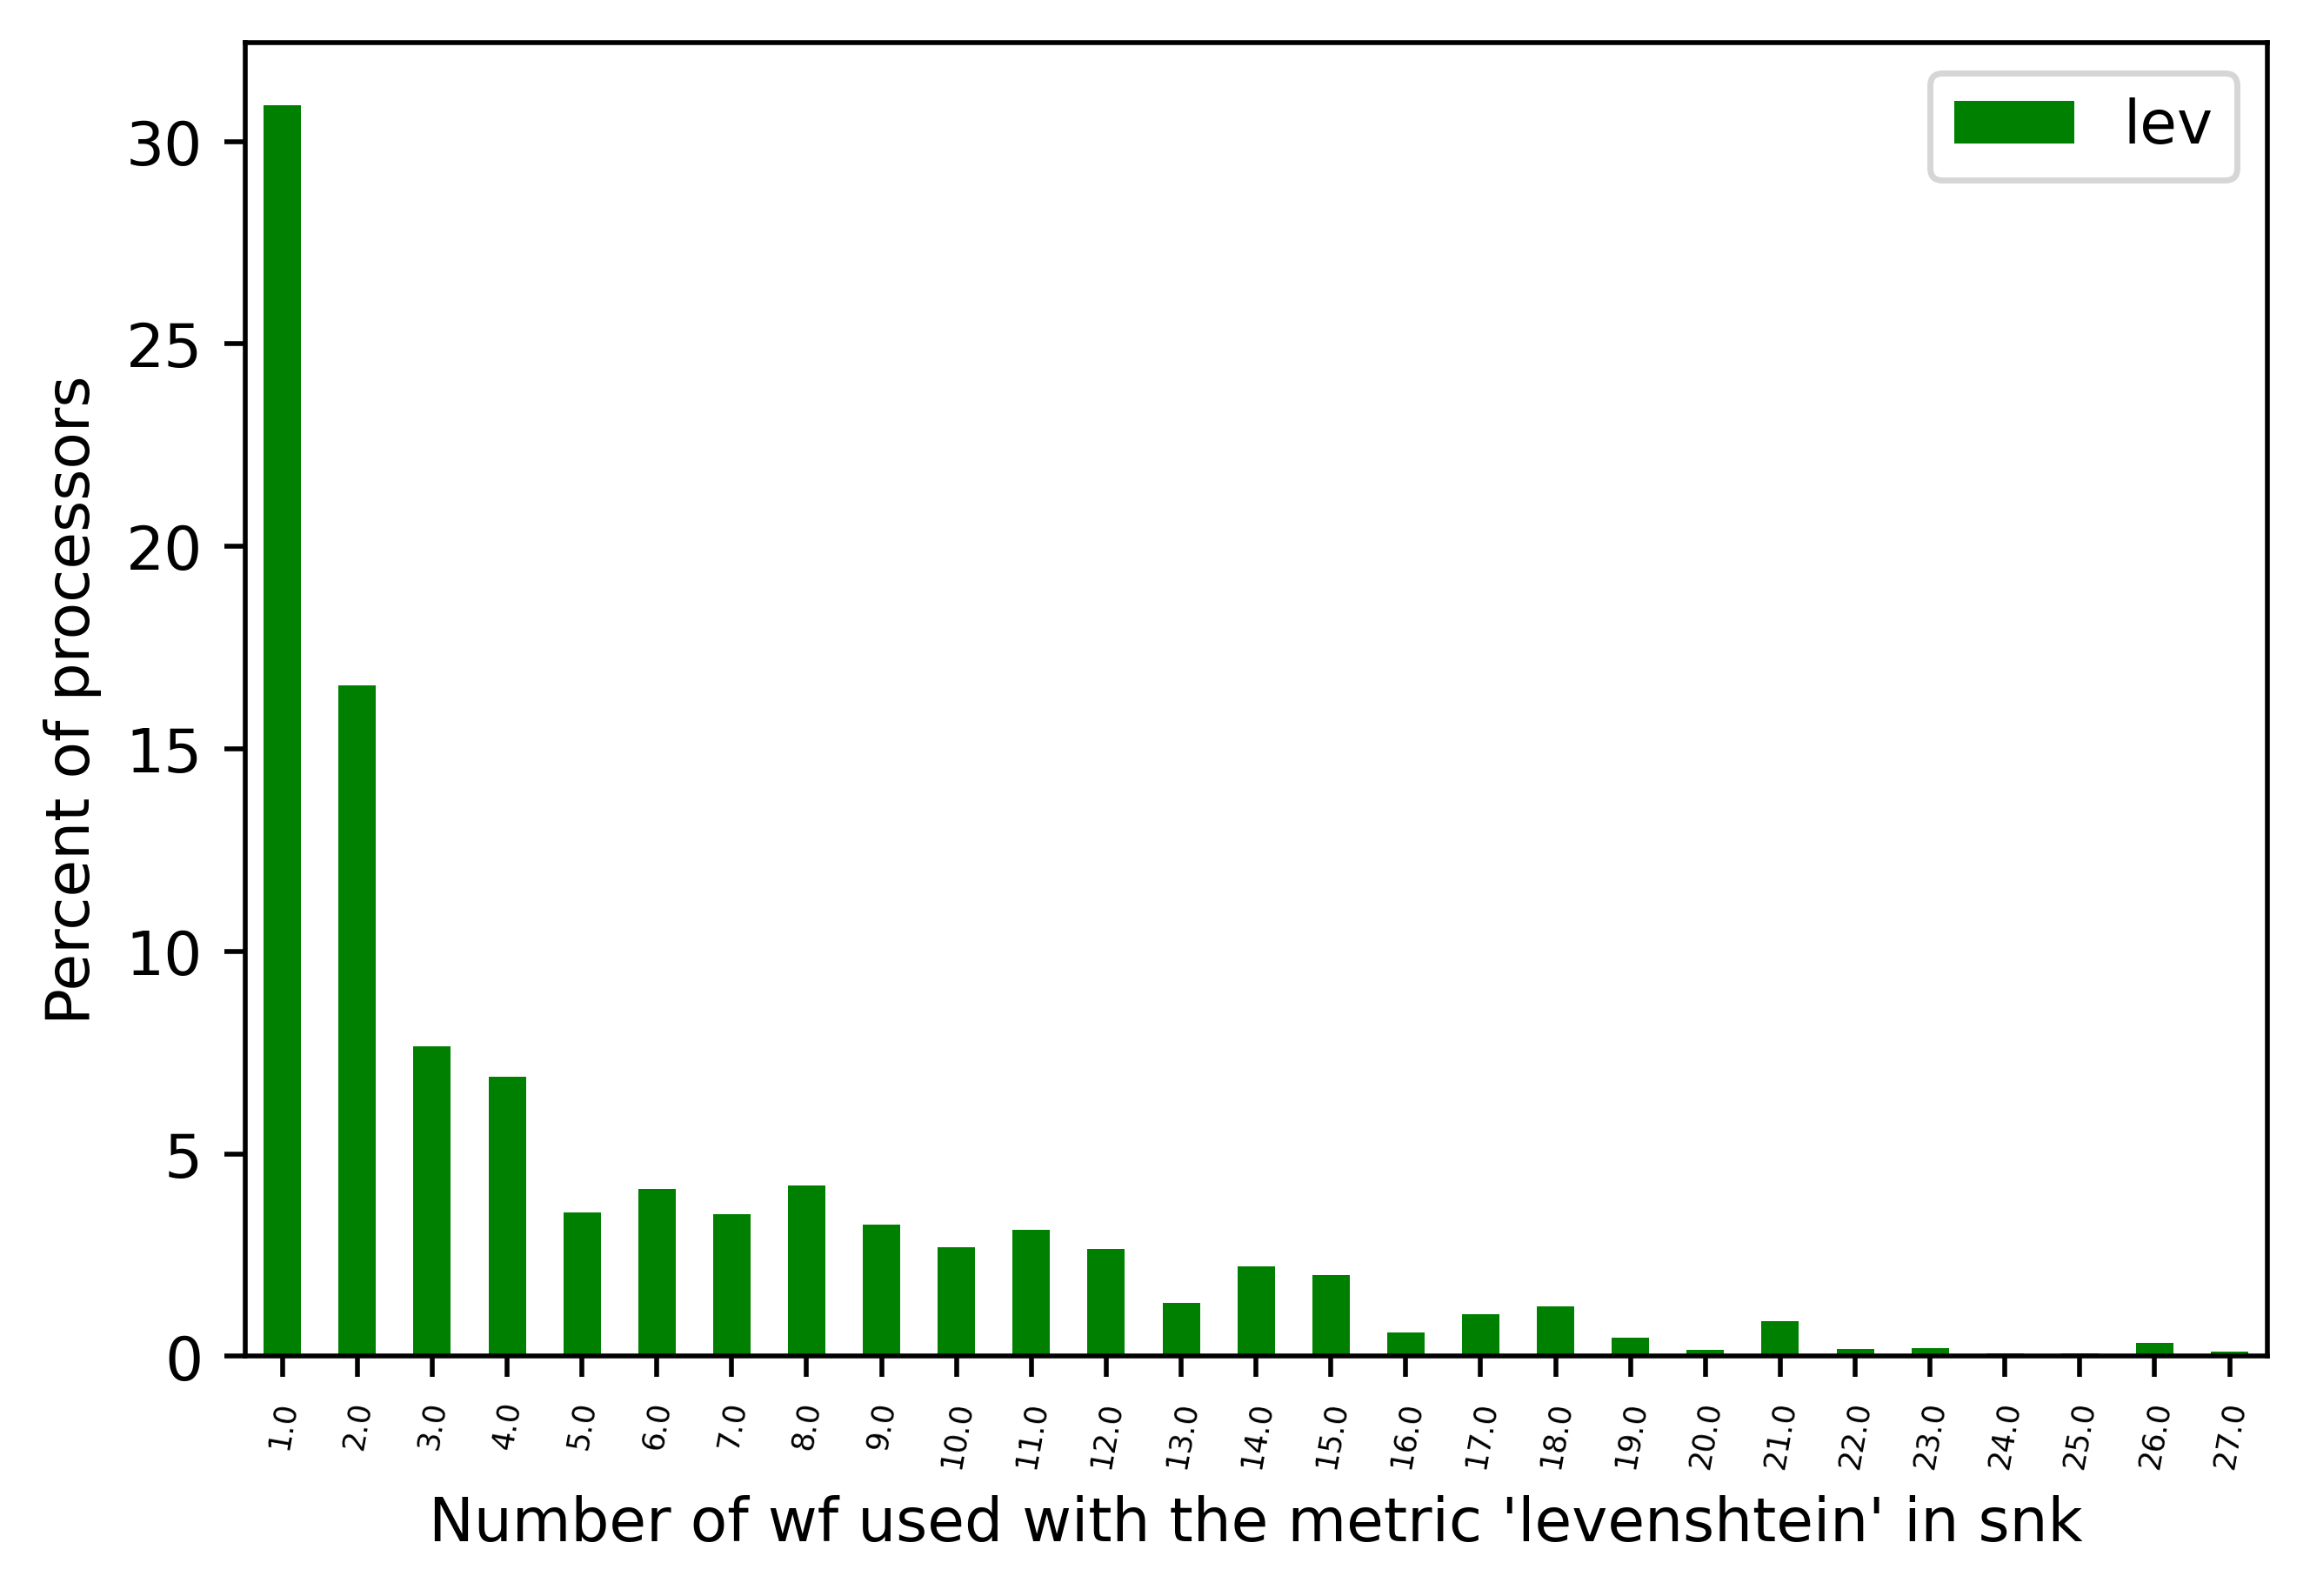

In [58]:
fig2 = df_snk_lev.plot(x="nb_reuse",y="prop_wf_lev", kind="bar", color = 'green', label = 'lev')
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=80, size=5)
fig2.set_xlabel("Number of wf used with the metric 'levenshtein' in snk")
fig2.set_ylabel('Percent of processors')
fig2.legend(loc='best')
#fig2.set_yscale('log')
plt.show()
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500

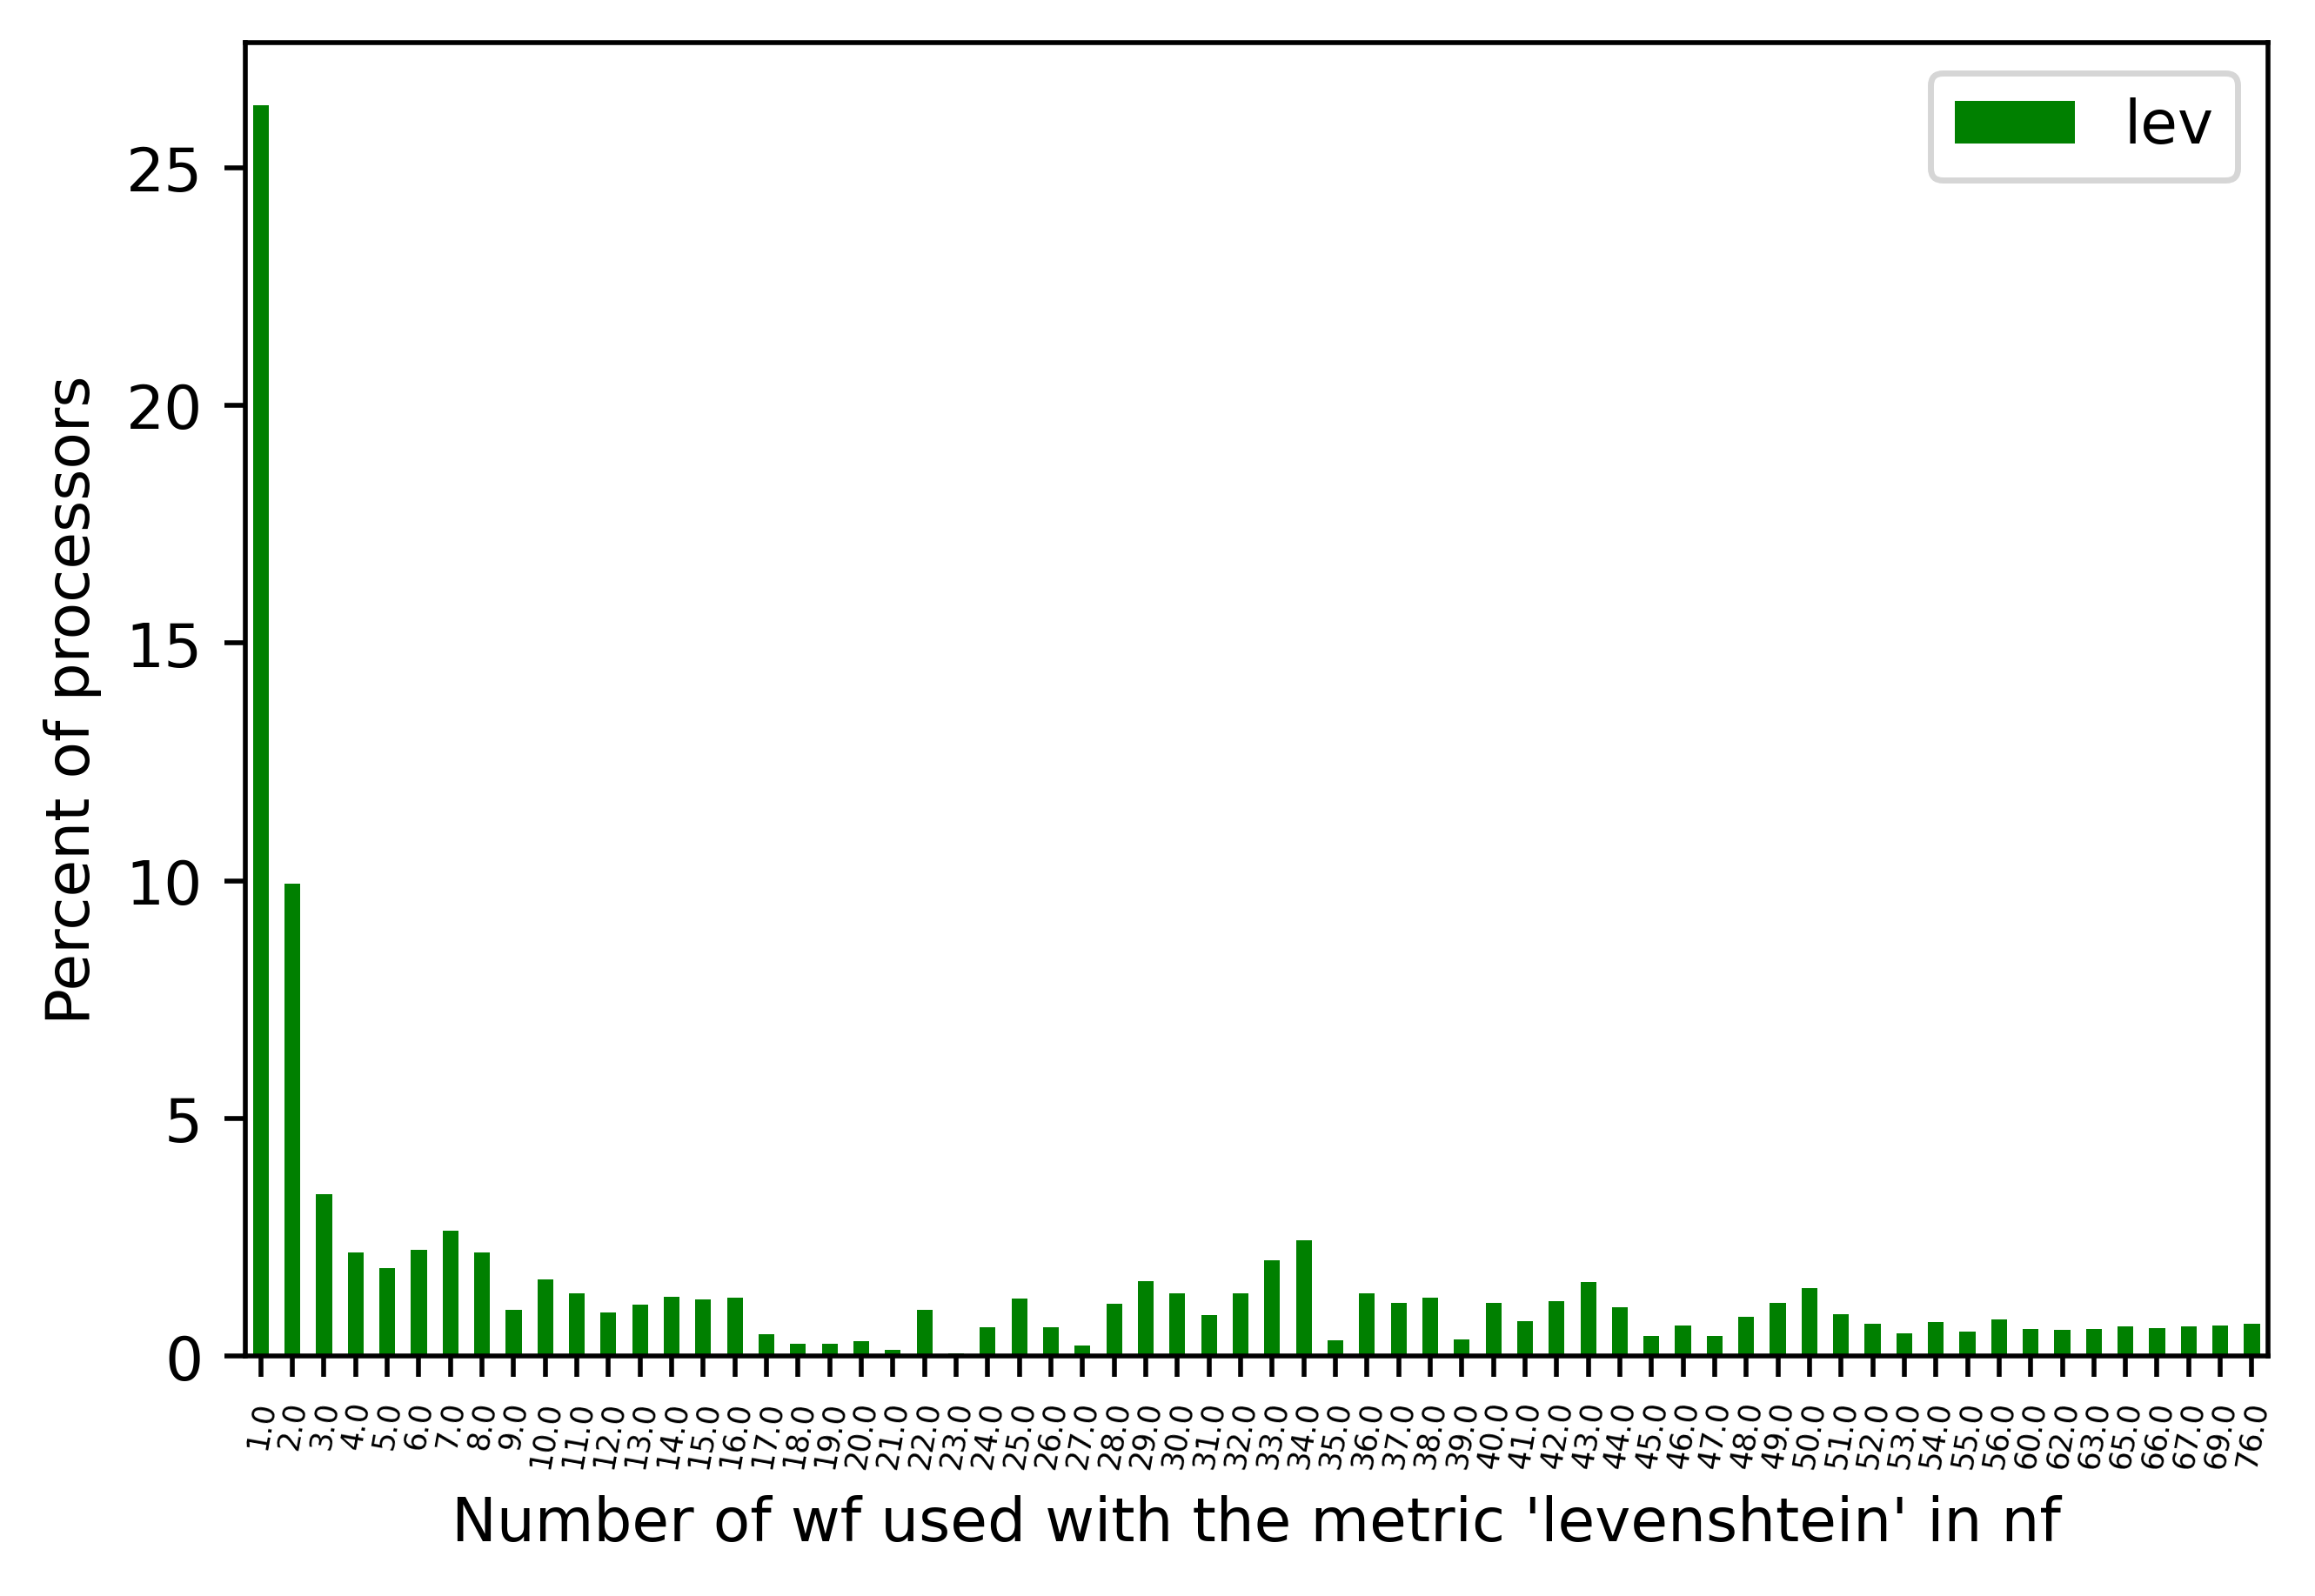

In [59]:
fig2 = df_nf_lev.plot(x="nb_reuse",y="prop_wf_lev", kind="bar", color = 'green', label = 'lev')
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=80, size=5)
fig2.set_xlabel("Number of wf used with the metric 'levenshtein' in nf")
fig2.set_ylabel('Percent of processors')
fig2.legend(loc='best')
#fig2.set_yscale('log')
plt.show()
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500

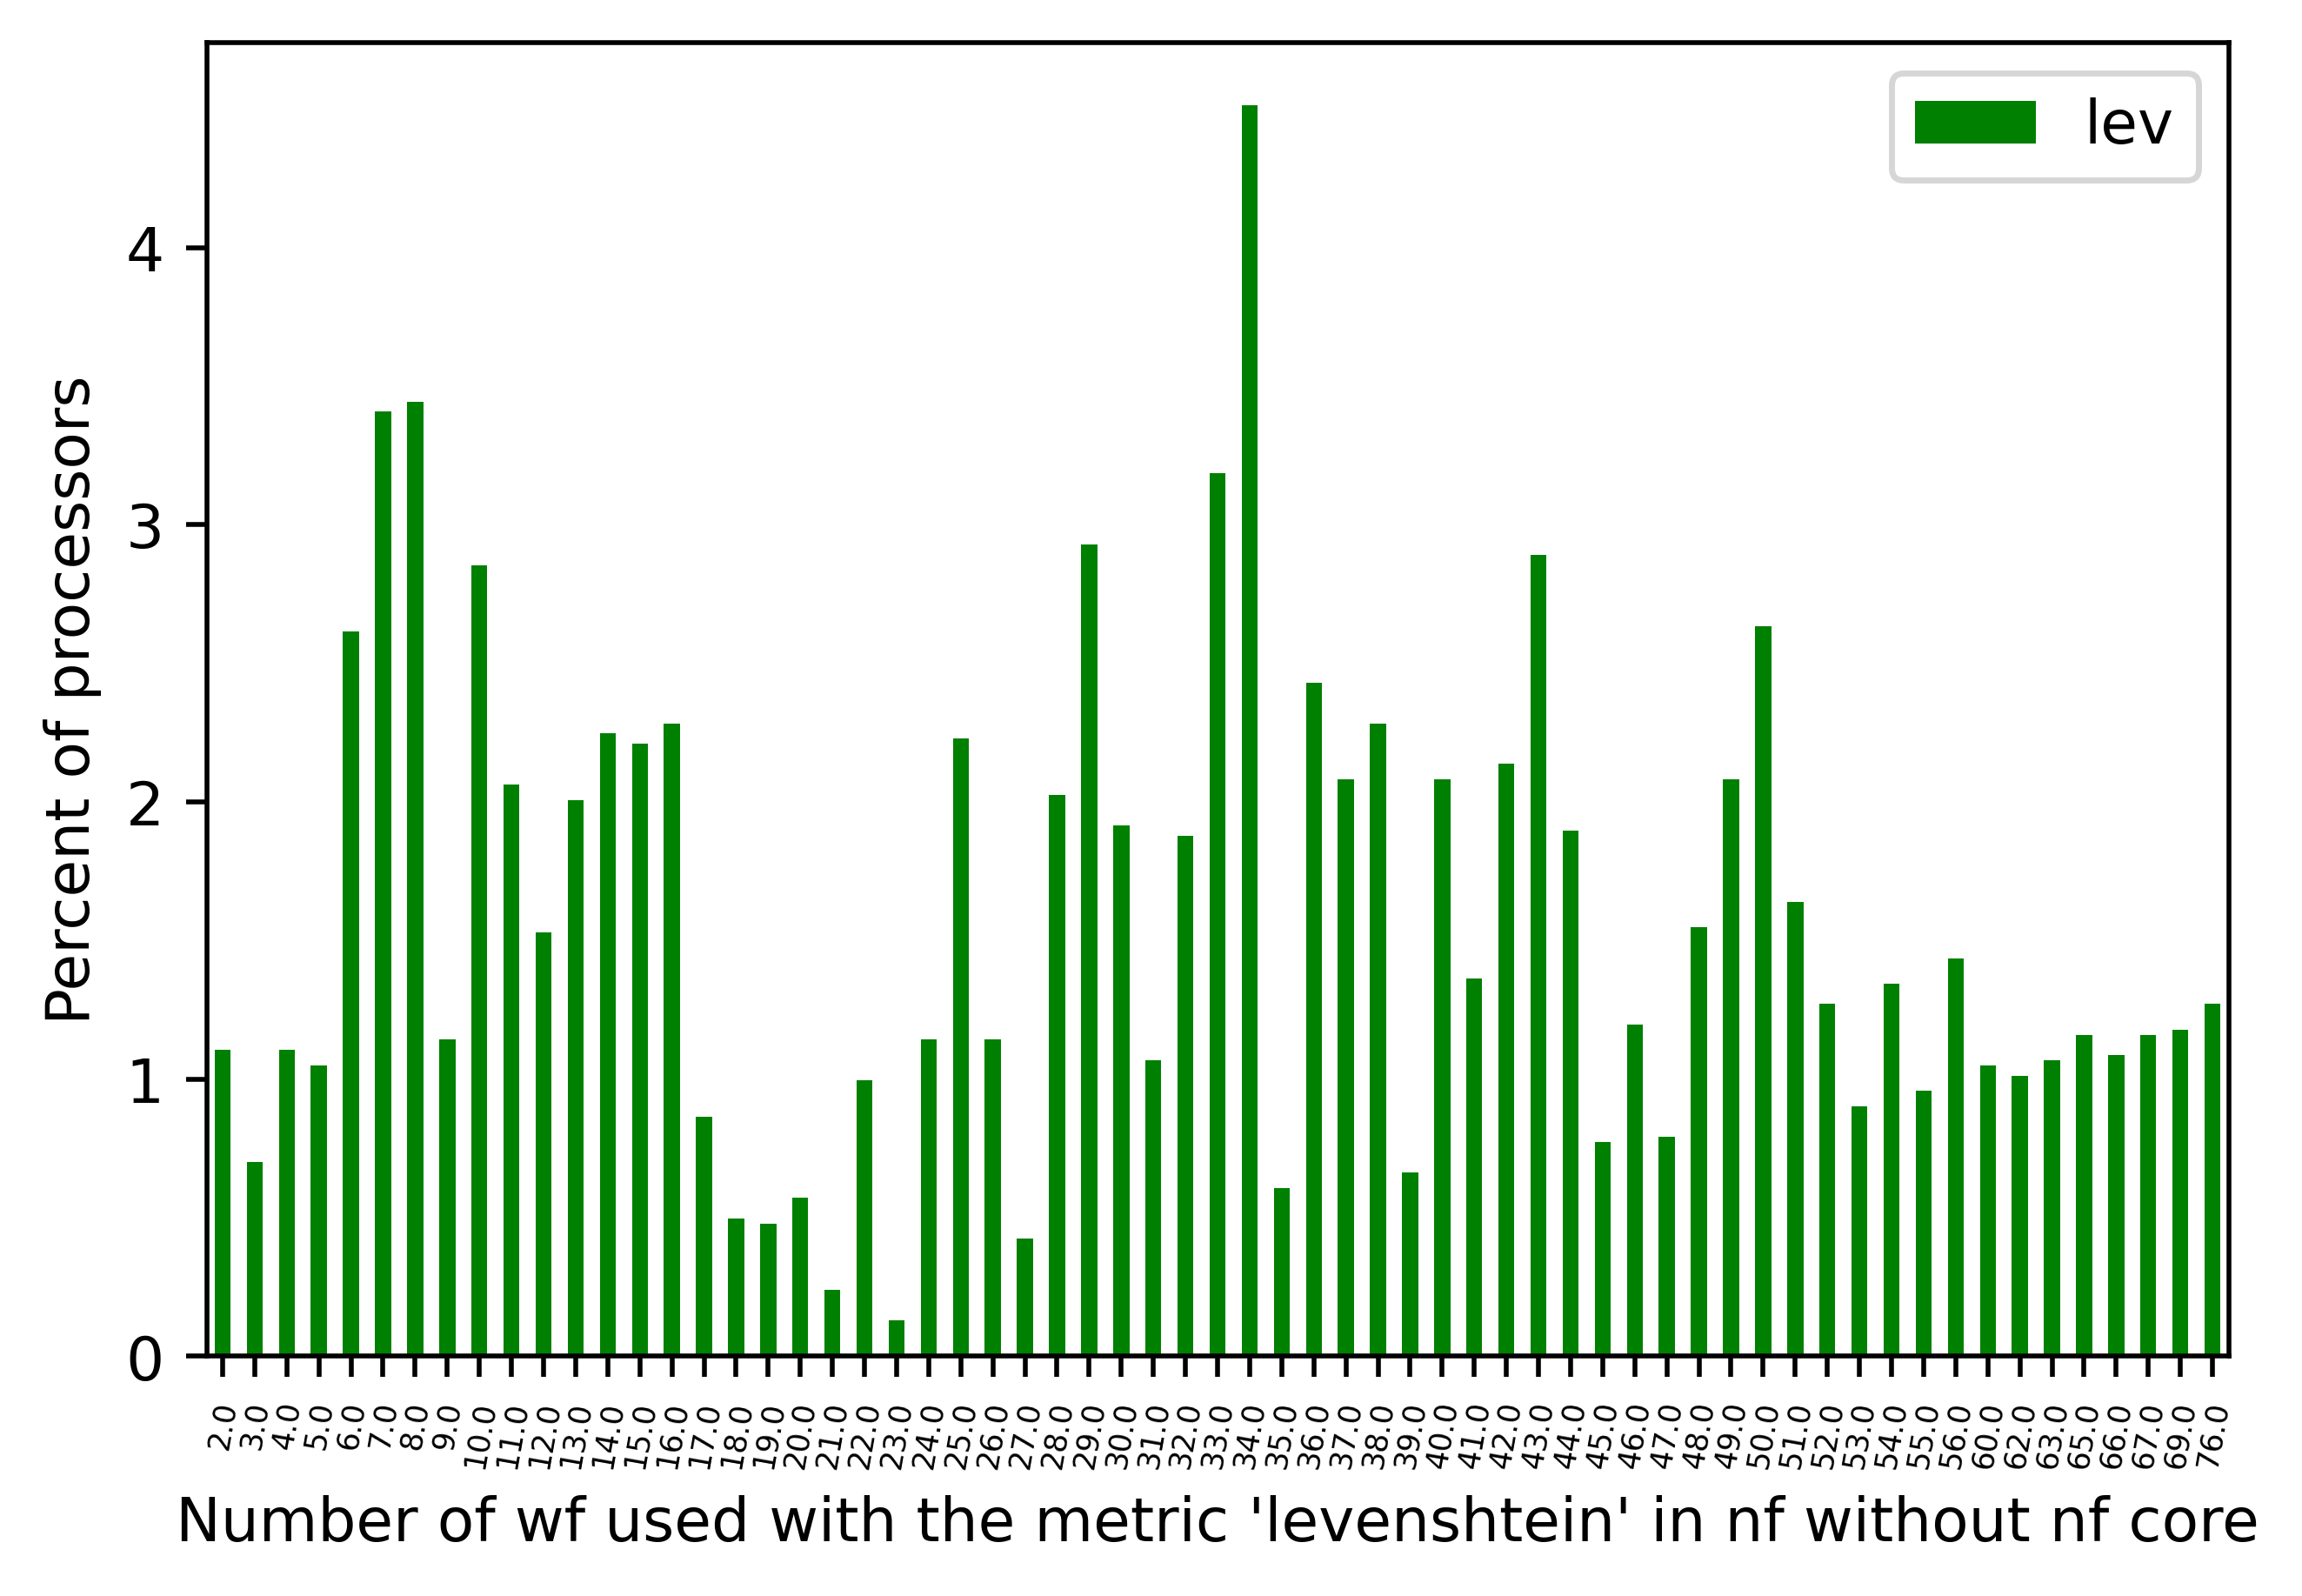

In [66]:
fig2 = df_nf_lev_wo_nfc.plot(x="nb_reuse",y="prop_wf", kind="bar", color = 'green', label = 'lev')
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=80, size=5)
fig2.set_xlabel("Number of wf used with the metric 'levenshtein' in nf without nf core")
fig2.set_ylabel('Percent of processors')
fig2.legend(loc='best')
#fig2.set_yscale('log')
plt.show()
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500

### Répartition de la réutilisation des process

Combien de fois chaque process est il réutilisé ?

In [88]:
def display_fig_stats_process(df_sim, df_sim_p, nb_proc, sys):
    df_sim_s = df_sim.sort_values(by=["nb_reuse"], ascending = False).head(nb_proc)
    df_sim_l = df_sim_p.sort_values(by=["nb_reuse"], ascending = False).head(nb_proc)
    ax = df_sim_s.plot(x='Unnamed: 0', y="nb_reuse", kind="bar", label = "times used tool", color = "orange")
    df_sim_l.plot(x='Unnamed: 0', y="nb_reuse", ax=ax ,  kind="bar", color = "red", label = "times used levenshtein")
    ax.set_title('Usage count of the '+str(nb_proc)+' most used processors for metrics tools and levenshtein in '+sys) 
    plt.xticks([])
    ax.set_yscale('log')
    #ax.set_xticklabels(l, rotation=80, size=5)
    ax.set_xlabel("Distinct processors")
    ax.set_ylabel("Nb of times used")
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return ax

Répartition de la réutilisation des process pour les métriques "tools" and "levenshtein" pour snakemake

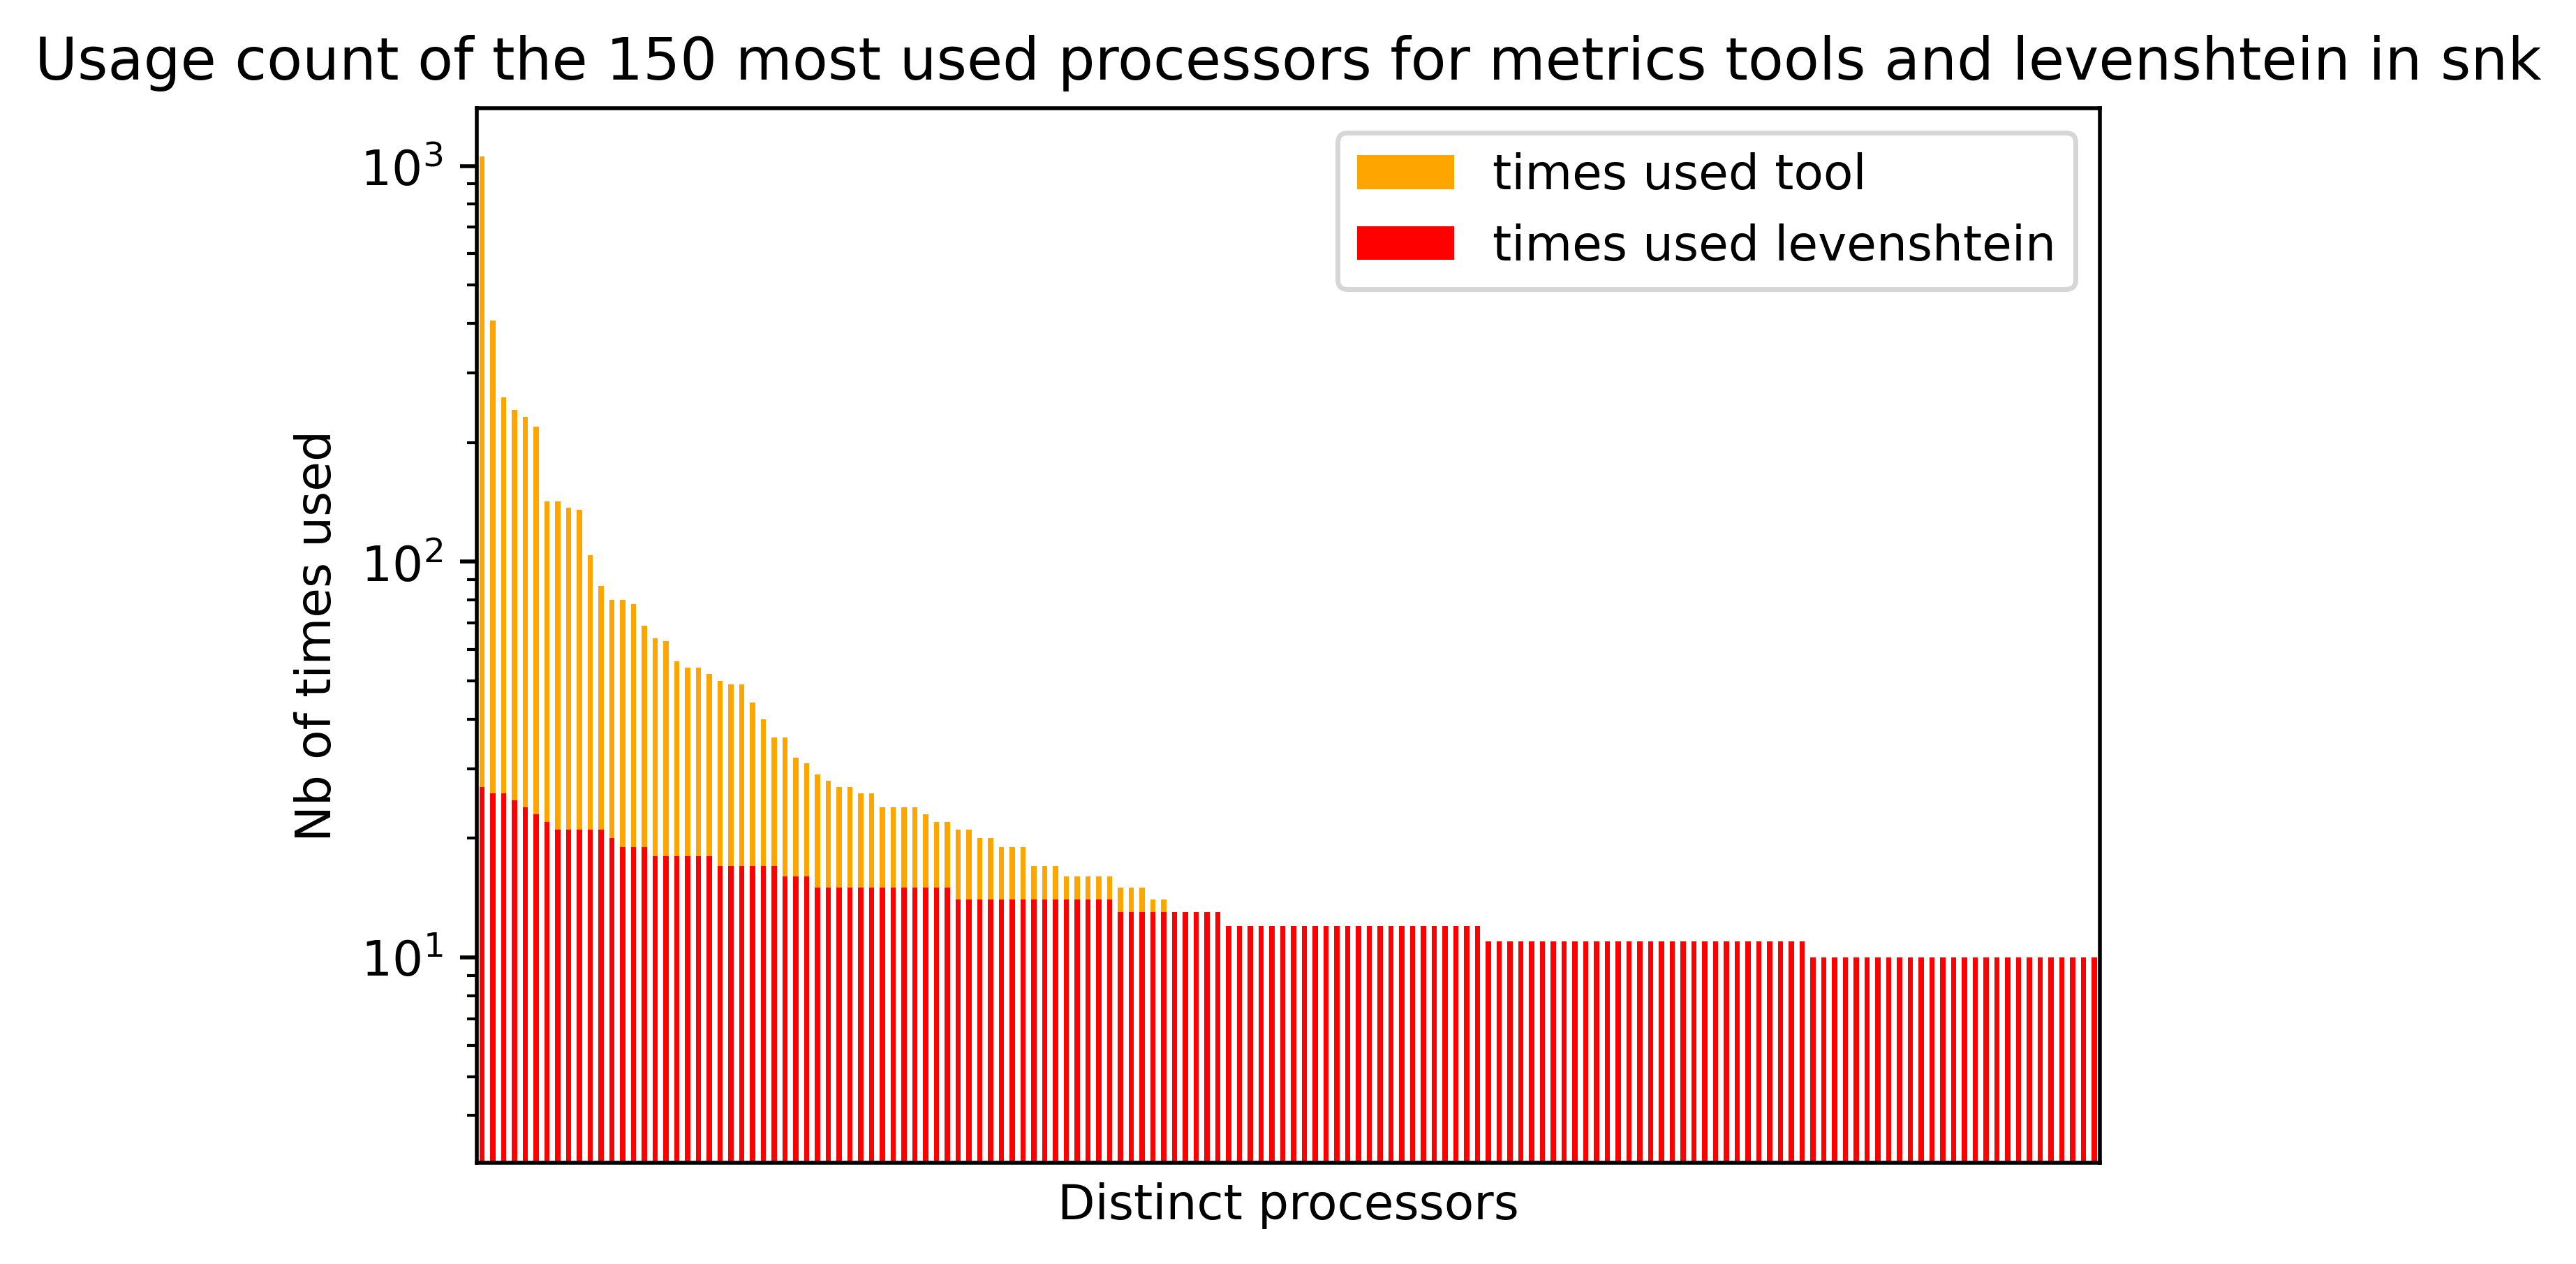

In [89]:
fig_snk = display_fig_stats_process(df_sim_snk,df_sim_snk_lev,150,"snk")

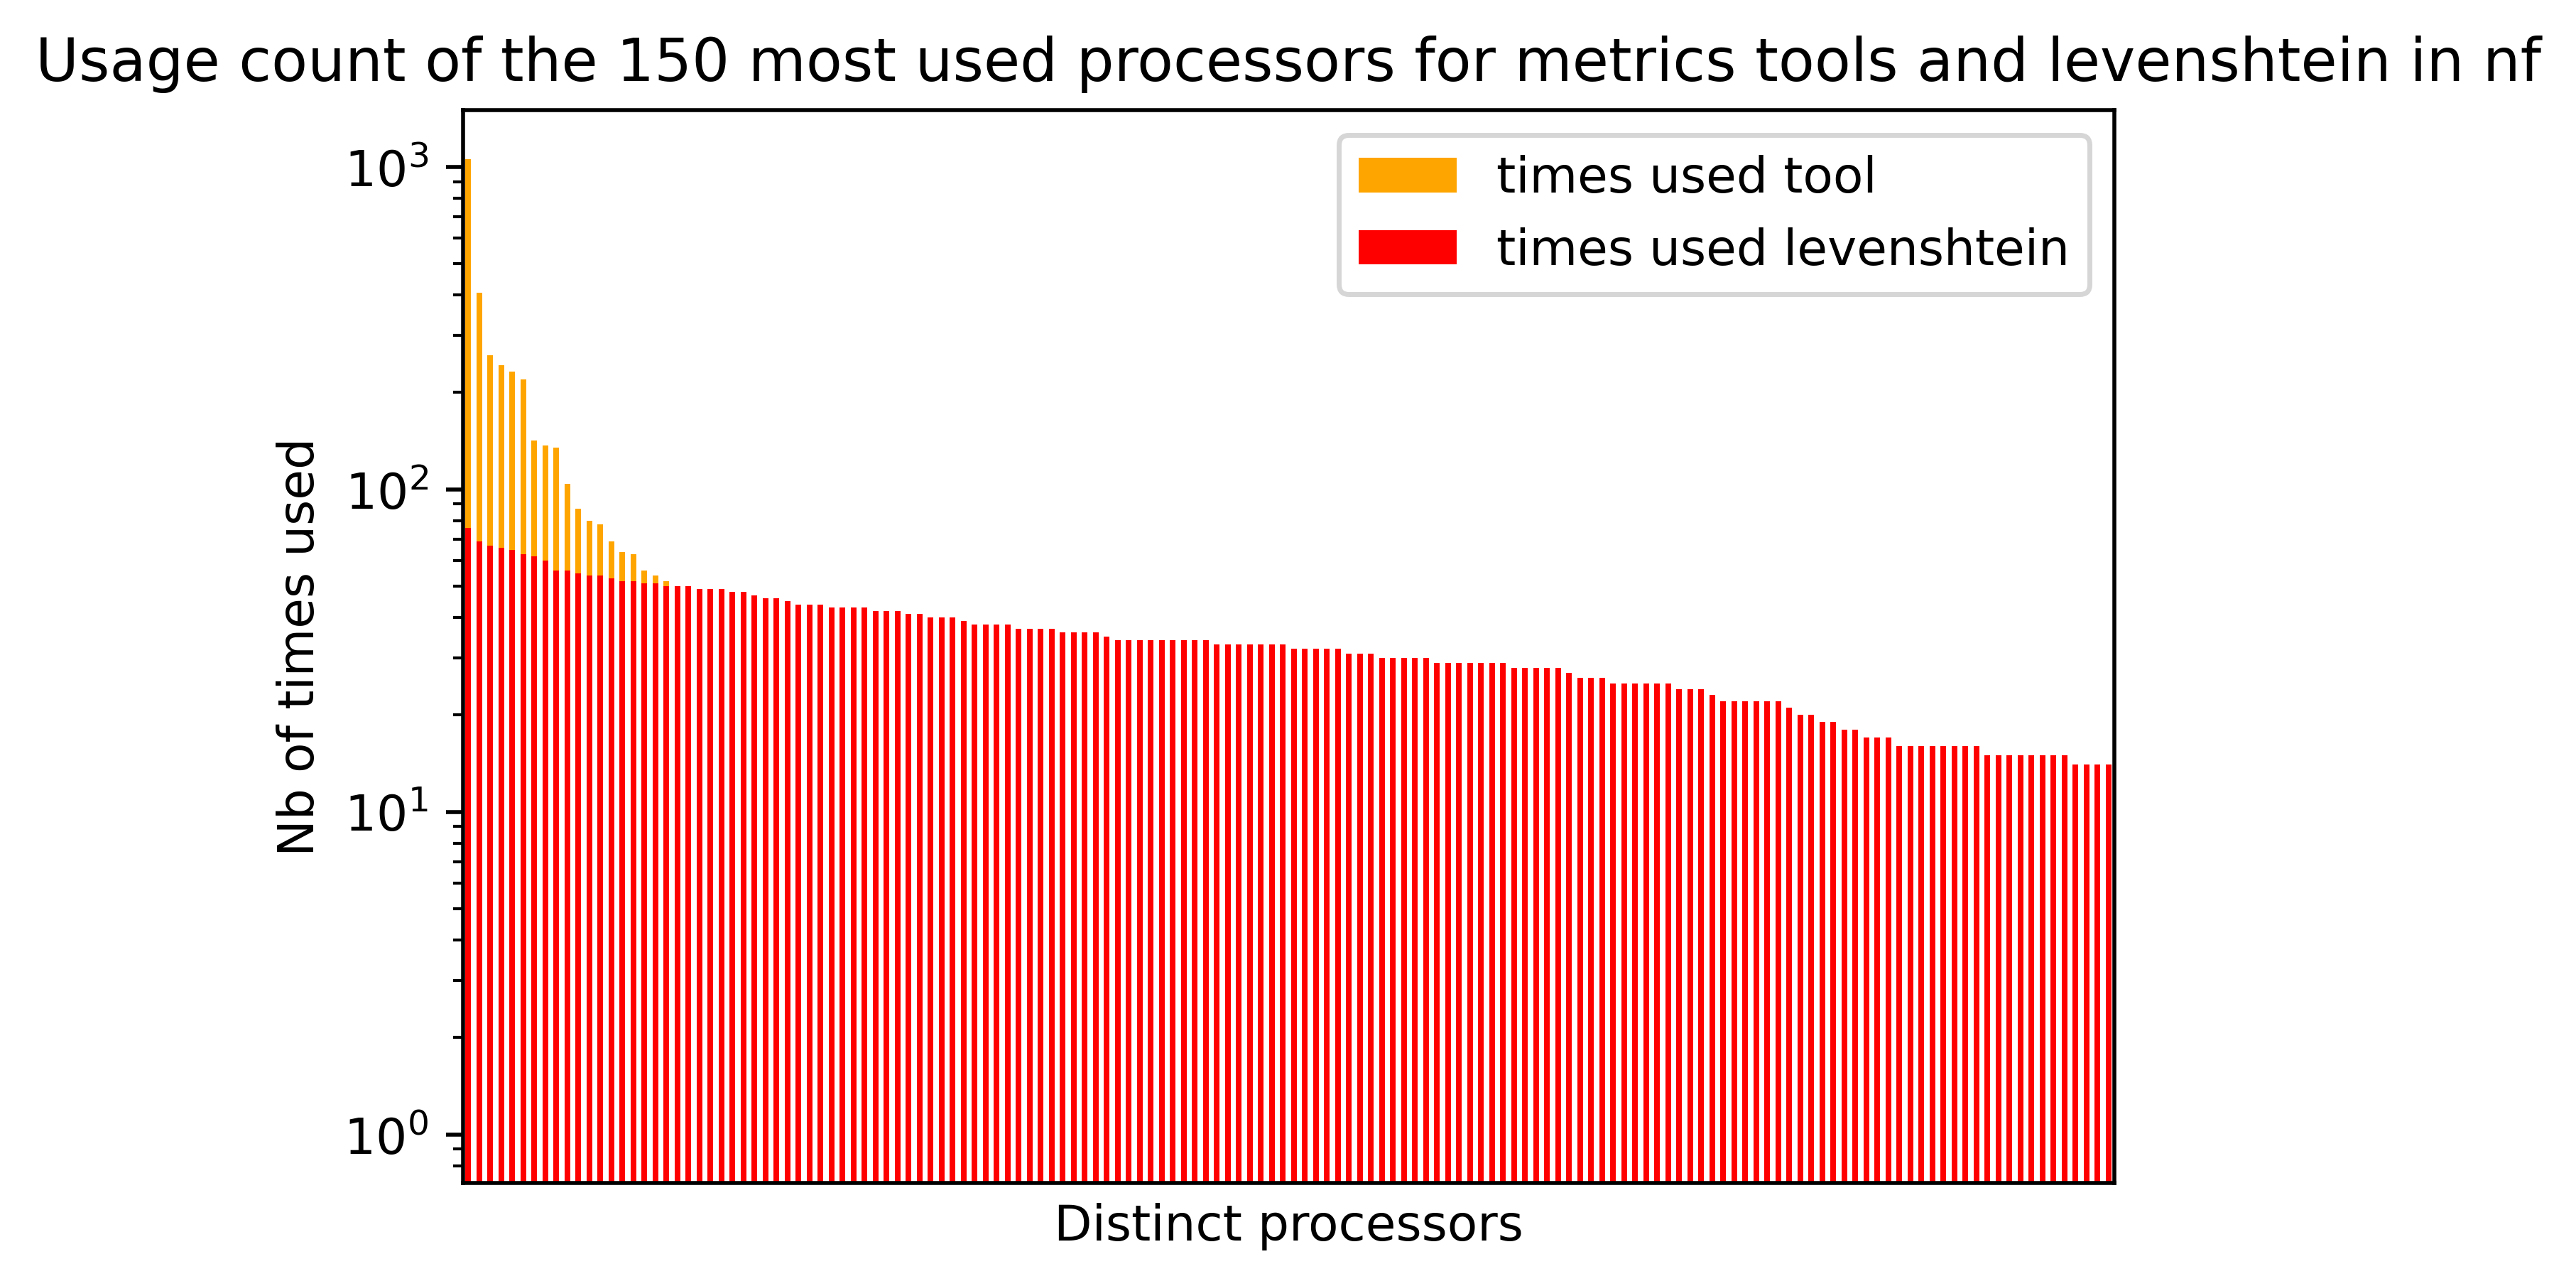

In [90]:
fig_nf = display_fig_stats_process(df_sim_nf,df_sim_nf_lev,150,"nf")

In order to see better what's going on with the levenshtein, let us look at this metric only :

In [70]:
def display_fig_stats_levenshtein(df_sim_lev,sys):
    ax = df_sim_lev.sort_values(by=["nb_reuse"], ascending = False).plot(x='Unnamed: 0', y="nb_reuse", kind="bar", label = "times used levenshtein", color = "red")
    ax.set_title('Usage count of processors for metric levenshtein for '+sys) 
    plt.xticks([])
    #ax.set_xticklabels(l, rotation=80, size=5)
    ax.set_xlabel("Distinct processors")
    ax.set_ylabel("Nb of times used")
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500


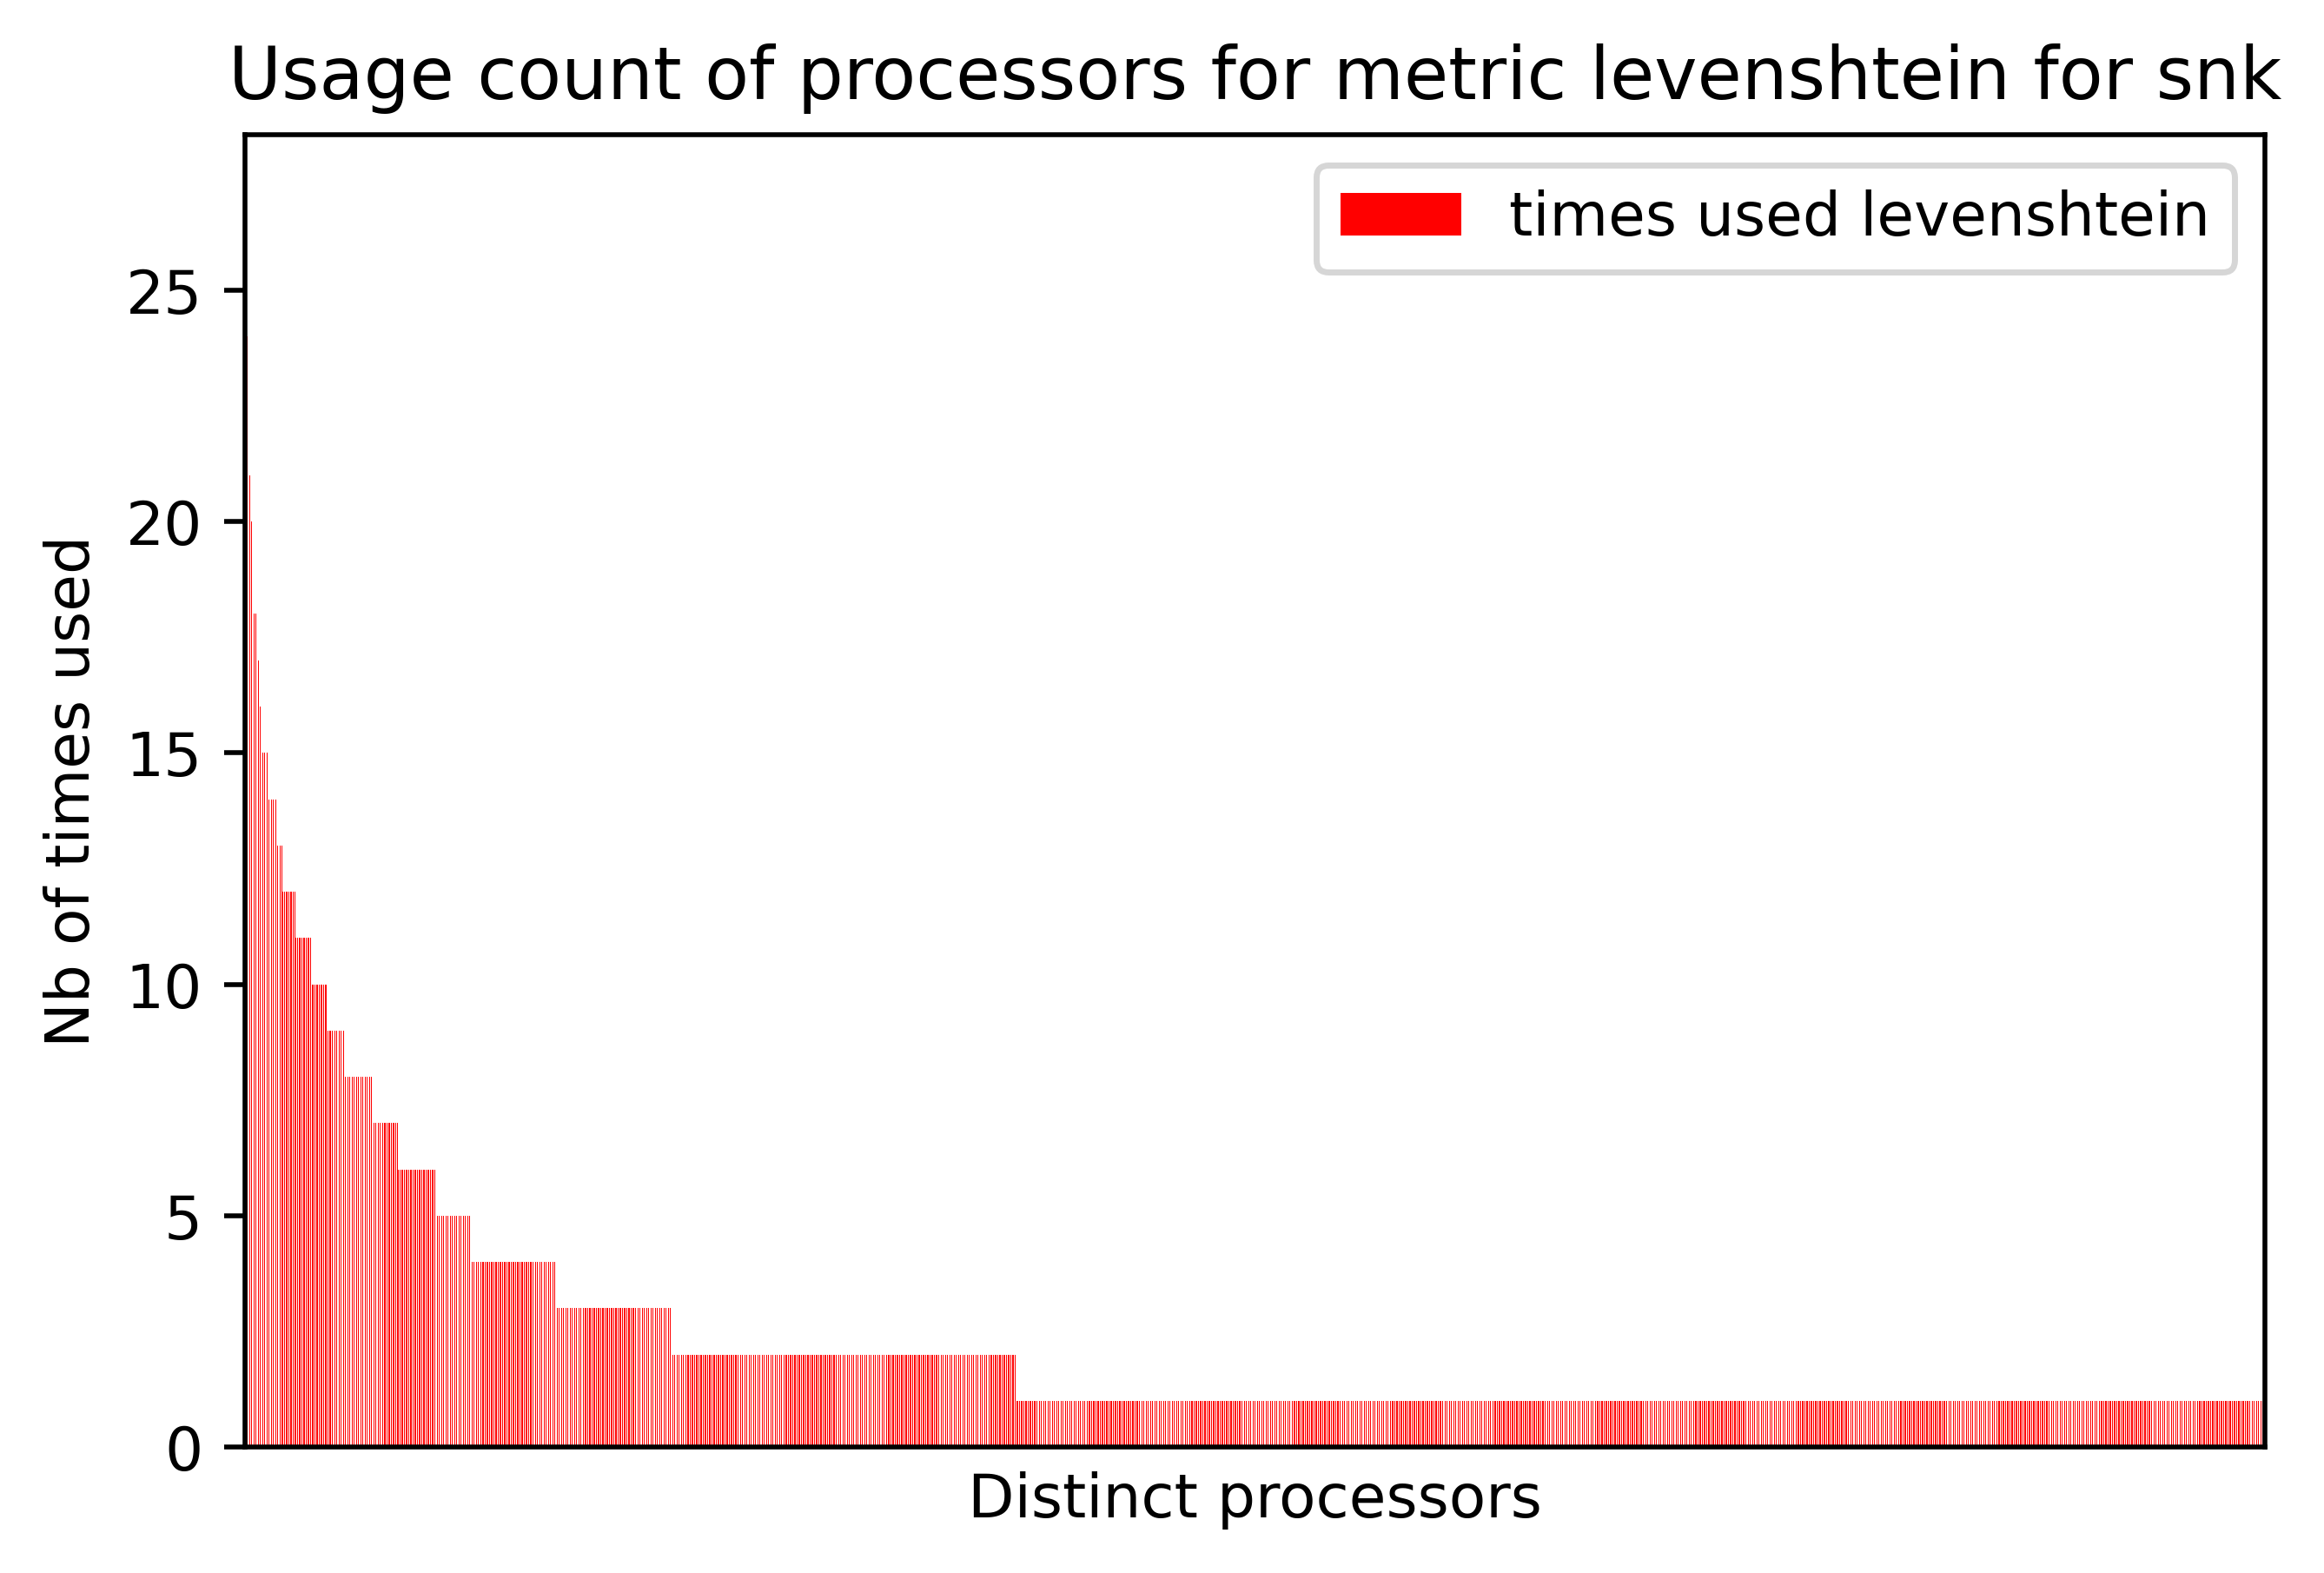

In [71]:
display_fig_stats_levenshtein(df_sim_snk_lev,"snk")

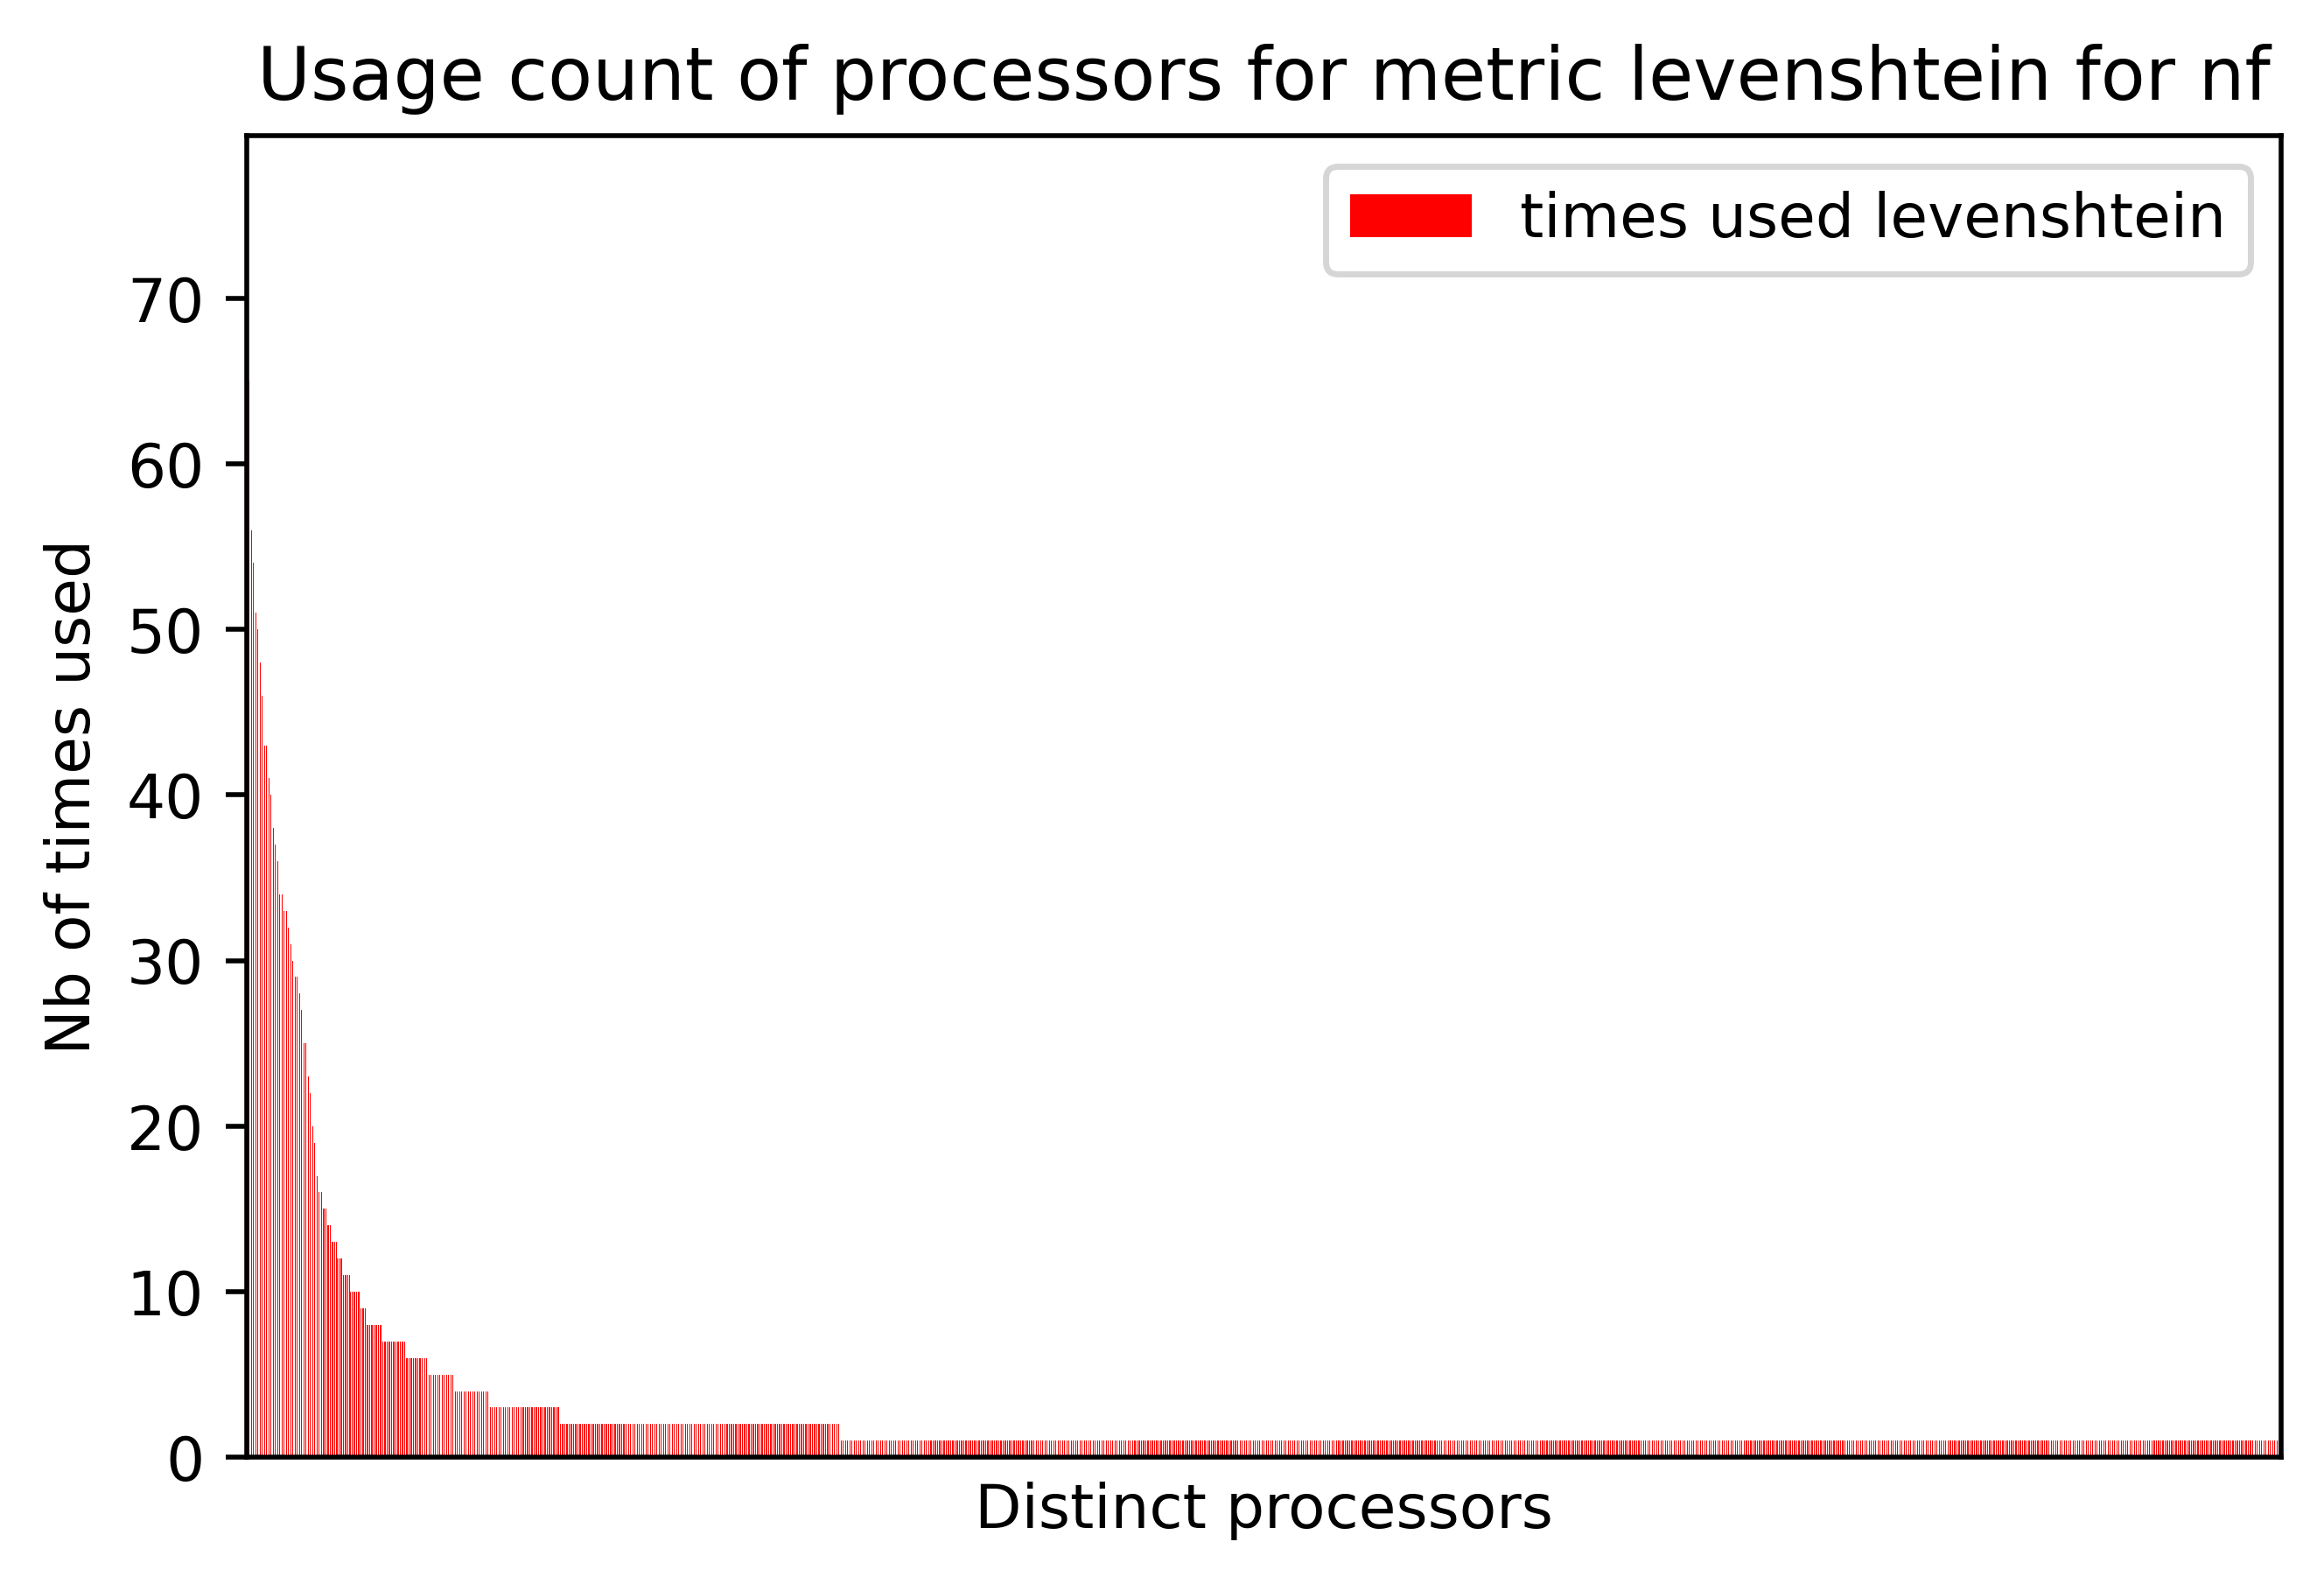

In [72]:
display_fig_stats_levenshtein(df_sim_nf_lev,"nf")

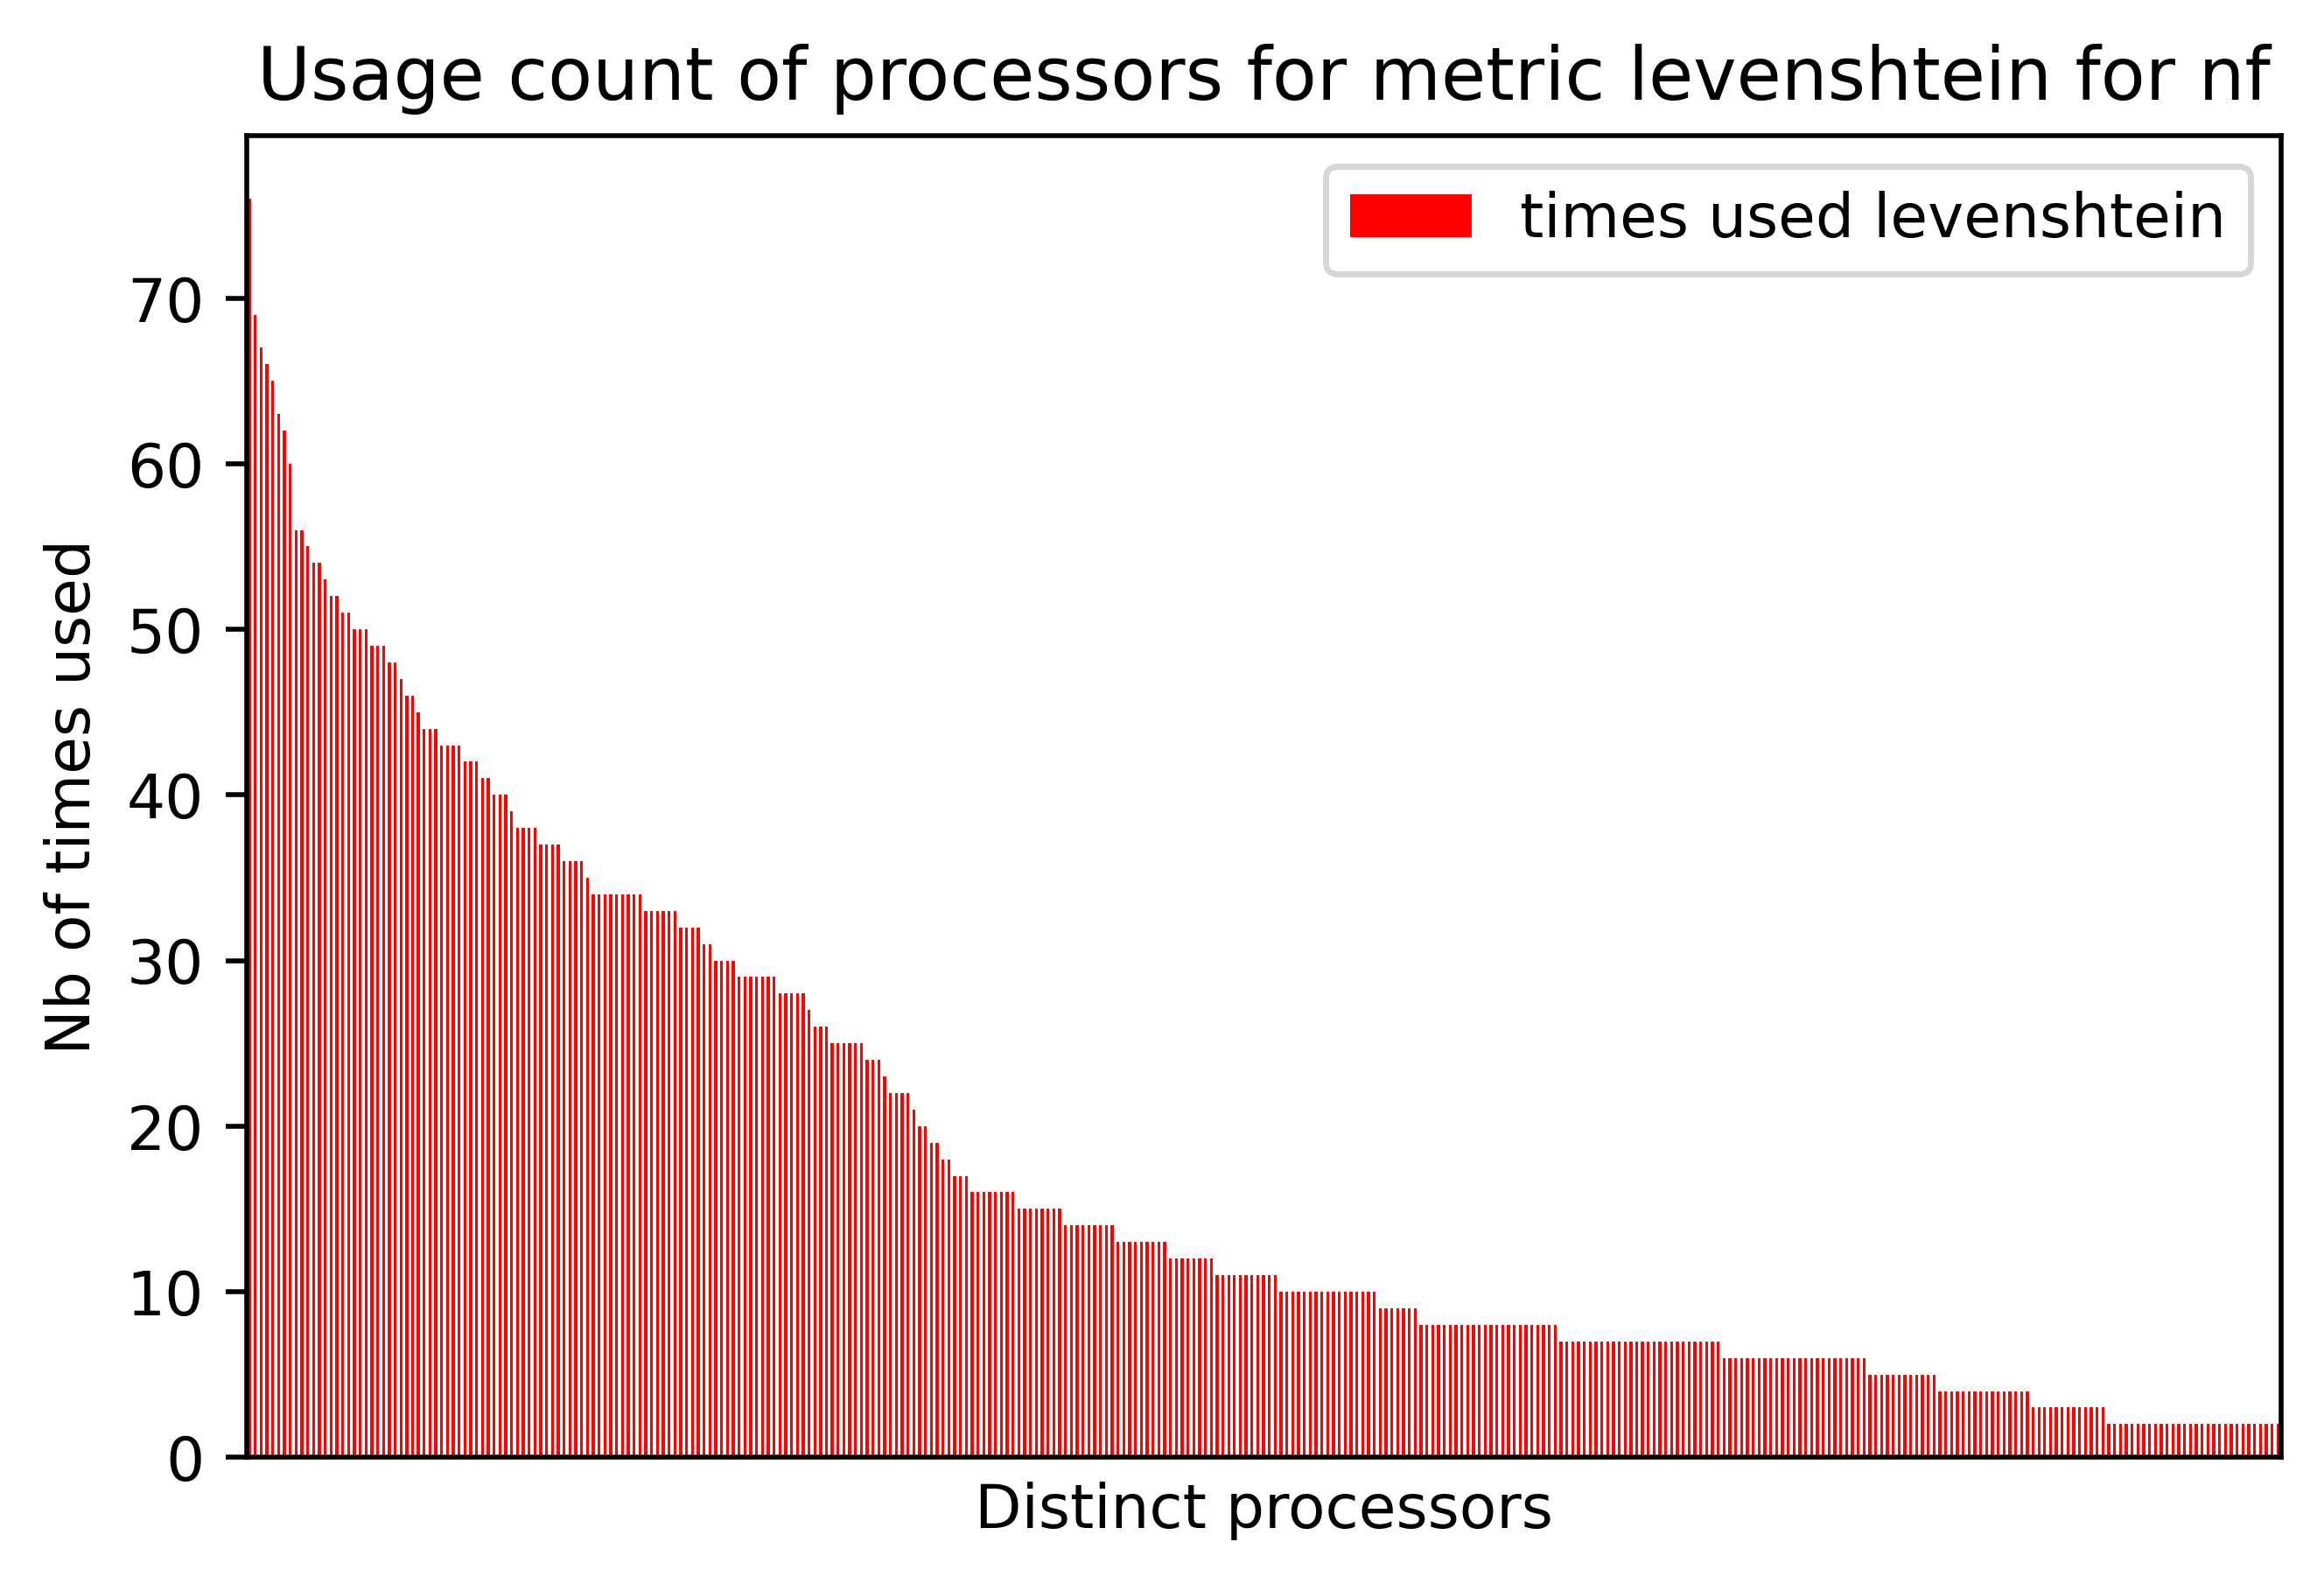

In [73]:
display_fig_stats_levenshtein(df_sim_nf_lev_wo_nfc,"nf")